# Mod 4 Project - Real Estate Portfolio Analysis

This notebook contains the data processing and analysis for the Flatiron School Data Science Bootcamp Mod 4 Project. In this module we're learning about time series analysis and SARIMA models. Below we'll analyze a dataset comprised of Zillow data - zipcodes from around the U.S., and seek to answer the question: 

_"What are the top 5 best zipcodes to invest in?_

In this case we'll act as a consultant to a real estate investment firm, but are otherwise left to our own devices to determine how to qualify the term "best". We'll further state our business case and assumptions below, but we'll start by stating that "best" will be more complex than the fastest growing and most expensive areas. We'll seek to create a balanced portfolio of properties that match or exceed market returns, but are spread across value segments to diversify our holdings and thereby mitigate risk. 

To make this notebook more readable I've placed a number of functions I created (or found) in two separate text files and imported them into this notebook. Check out **'ryans_ts_helper.py'** and **'SARIMA_grid_search.py'** to see some of those functions. 

See those files and presentation here:

[ryans_ts_helper.py](https://github.com/rab175/dsc-mod-4-project-online-ds-pt-071519/blob/master/ryans_ts_helper.py)

[SARIMA_grid_search.py](https://github.com/rab175/dsc-mod-4-project-online-ds-pt-071519/blob/master/SARIMA_grid_search.py)

[Non-technical Presentation](https://docs.google.com/presentation/d/17PkAMyvhgYcwayZvrQ0b8f4zLqRy2PF1TfWArZ2nbGY/edit?usp=sharing)

## Outline 

This notebook is organized as follows: 
1. Business Case
2. Data Import and Cleaning
3. Exploratory Data Analysis
4. Modeling
5. Results and Conclusions

## Business Case

Our real estate investment strategy will involve choosing a combination of 5 separate zip codes from across the United States that range from high to low priced properties, and determining a strategy with which to invest $50mm across them. This strategy is focused on acquiring a diverse range of assets, acknowledging that it also may involve working in very different markets and locales, and may involve acquiring properties that have very different management and sales requirements. Nevertheless we believe that this strategy will allow us to benefit from having access to the performance of a wide range of properties and markets, both helping spread risk, and potentially find opportunities for over-performance. 

We will disperse our $50mm of investment resources evenly across the 5 zipcodes, and across three different value segments: High, Medium, and Low cost areas, defined in more detail below. 

Ultimately our goal is to implement a strategy that will at least match or exceed the performance of current housing indices.

**Federal Housing Finance Agency (FHFA) Housing Price Index (HPI)**

To get an idea of how housing prices have grown recently we can quickly take a look at FHFA data to set a baseline. 

FHFA data can be found at: 

https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx#mpo

In [1]:
#import data and format
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel('HPI_PO_monthly_hist.xls', header=2)
df = df.dropna()
df['Month'] = pd.to_datetime(df.Month)
df = df.set_index('Month')
df.head(2)

East North Central\n(NSA)  East North Central\n(SA)  \
Month                                                             
1991-01-01                      100.0                    100.00   
1991-02-01                      101.0                    101.08   

            East South Central\n(NSA)  East South Central\n(SA)  \
Month                                                             
1991-01-01                     100.00                    100.00   
1991-02-01                     100.86                    100.43   

            Middle Atlantic\n(NSA)  Middle Atlantic\n(SA)  Mountain\n\n(NSA)  \
Month                                                                          
1991-01-01                  100.00                 100.00             100.00   
1991-02-01                   99.99                 100.21              98.41   

            Mountain\n\n(SA)  New England\n\n(NSA)  New England\n\n(SA)  \
Month                                                                     
1991-01-01            100.00                100.00               100.00   
1991-02-01             98.54                101.91               102.37   

            Pacific\n\n(NSA)  Pacific\n\n(SA)  South Atlantic\n(NSA)  \
Month                                                                  
1991-01-01            100.00           100.00                 100.00   
1991-02-01            100.18           100.49                 100.56   

            South Atlantic\n(SA)  West North Central\n(NSA)  \
Month                                                         
1991-01-01                100.00                     100.00   
1991-02-01                100.36                     100.64   

            West North Central\n(SA)  West South Central\n(NSA)  \
Month                                                             
1991-01-01                    100.00                     100.00   
1991-02-01                    100.63                      99.91   

            West South Central\n(SA)  USA\n\n(NSA)  USA\n\n(SA)  
Month                                                            
1991-01-01                    100.00        100.00       100.00  
1991-02-01                     99.69        100.41       100.44

Our analysis will focus on roughly 10 years of data after the 2008 housing crisis, so we'll look at the same here. 

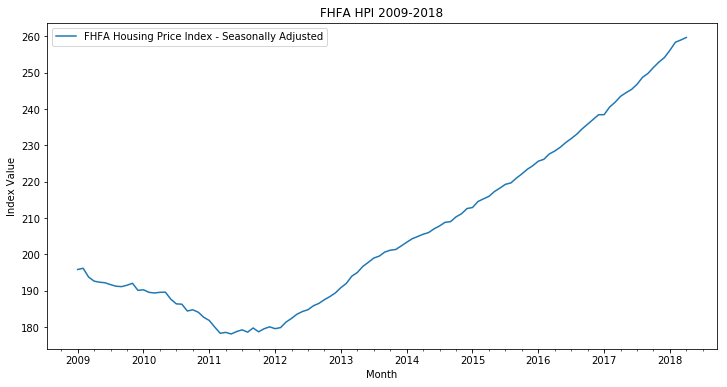

In [2]:
# plot the time period under consideration
df['USA\n\n(SA)']['2009':'2018-04'].plot(label='FHFA Housing Price Index - Seasonally Adjusted', 
                                         figsize = (12,6))
plt.legend()
plt.ylabel('Index Value')
plt.title('FHFA HPI 2009-2018')
plt.show()

In [3]:
# calculate the change in index values over the total time and for the last 3 years
period_start = float(df['USA\n\n(SA)']['2009-01'])
period_end = float(df['USA\n\n(SA)']['2018-04'])
three_years_back = float(df['USA\n\n(SA)']['2015-04'])

total_growth = round((period_end-period_start)/period_start, 2) * 100
three_yr_growth = round((period_end-three_years_back)/three_years_back, 2) * 100

print(f'It appears that home prices have grown roughly {total_growth}% over the total time,')
print(f'and {three_yr_growth}% over the last three years.')

It appears that home prices have grown roughly 33.0% over the total time,
and 20.0% over the last three years.


As we assess areas to invest in we will keep these rates in mind as a benchmark. 

## Data

We'll begin with importing the necessary libraries we'll need for our analysis and taking an initial look at our data.

Our data comes from Zillow, and is comprised of the monthly median home prices for over 14,000 unique zipcodes from April 1996 to April 2018. We'll get a look at the size and shape of our data, look to see what data is missing, and ultimately select down to just the data we will need to conduct our analysis. 

In [4]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
import itertools
%matplotlib inline
plt.style.use('fivethirtyeight')
#turning off warnings for final version to make notebook easier to read
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

from joblib import Parallel
from multiprocessing import cpu_count

# these are my own files - 'SARIMA_grid_search.py' is a great peice of code I found on Machine Learning Mastery (link in file)
# and 'ryans_ts_helper.py' is a collection of my own functions I created for this project
from SARIMA_grid_search import *
from ryans_ts_helper import * 

In [5]:
# import zillow data and check info and first 5 lines
df = pd.read_csv('zillow_data.csv')
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


None

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06   ...     2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0   ...     1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0   ...      308000   310000   312500   
2         3  210400.0  212200.0  212200.0   ...      321000   320600   320200   
3         4  498100.0  500900.0  503100.0   ...     1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0   ...      119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

We can see that: 
* Our data has 14,723 rows and 272 columns
* Most of the data is integers(49 columns) and floats (219 columns)
* There are two identifiers for each row, 'RegionID' and 'RegionName'
    * We'll look to see if they are unique, and also see which one is actually the zipcode
    
Let's count the number of unique values for our first six columns.

In [6]:
# count the number of unique values for the first 6 columns
df.nunique()[:6]

RegionID      14723
RegionName    14723
City           7554
State            51
Metro           701
CountyName     1212
dtype: int64

It appears that RegionID and RegionName are both entirely unique. A little in depth analysis (looking up my own zipcode) tells us that RegionName is the column that represents zipcodes. We can drop RegionID in the next section. 

Otherwise it appears that we have all 50 states plus Washington, D.C. represented, and a large number of cities and metro areas represented. Later in our analysis we'll take some of this into account to see if there are geographic considerations we can take into account when choosing zipcodes for our portfolio.

Before we start processing our data let's also check for null values.

In [7]:
# check columns for null values and count them
null_columns = df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Metro      1043
1996-04    1039
1996-05    1039
1996-06    1039
1996-07    1039
1996-08    1039
1996-09    1039
1996-10    1039
1996-11    1039
1996-12    1039
1997-01    1039
1997-02    1039
1997-03    1039
1997-04    1039
1997-05    1039
1997-06    1039
1997-07    1038
1997-08    1038
1997-09    1038
1997-10    1038
1997-11    1038
1997-12    1038
1998-01    1036
1998-02    1036
1998-03    1036
1998-04    1036
1998-05    1036
1998-06    1036
1998-07    1036
1998-08    1036
           ... 
2012-01     224
2012-02     224
2012-03     224
2012-04     224
2012-05     224
2012-06     224
2012-07     206
2012-08     206
2012-09     206
2012-10     206
2012-11     206
2012-12     206
2013-01     151
2013-02     151
2013-03     151
2013-04     151
2013-05     151
2013-06     151
2013-07     109
2013-08     109
2013-09     109
2013-10     109
2013-11     109
2013-12     109
2014-01      56
2014-02      56
2014-03      56
2014-04      56
2014-05      56
2014-06      56
Length: 220, dtype: int6

There are a lot of missing values! 
* 220 columns are missing data
* 1,043 rows do not have a value for 'Metro' 
* Many values in the 1990's are missing

We'll address this in the next section while we're processing our data. 

## Data Processing

In this section we will process our data and begin to prepare it for analysis. We will fist deal with missing values. Next, we'll select data that meets the requirements of our business case and create segments for analysis. From there we'll move into exploratory analysis. 

### Missing Metro Data

Above we saw that there are 1,043 missing values for 'Metro'. Let's take a closer look at Metro and City to see if there is a relationship we can use to impute values for what is missing.

In [8]:
# Look at the first 15 combinations of 'City' and 'Metro'
df[['City', 'Metro']].head(15)

City              Metro
0         Chicago            Chicago
1        McKinney  Dallas-Fort Worth
2            Katy            Houston
3         Chicago            Chicago
4         El Paso            El Paso
5         Houston            Houston
6        New York           New York
7         Chicago            Chicago
8            Katy            Houston
9   San Francisco      San Francisco
10       New York           New York
11   The Villages       The Villages
12       New York           New York
13       New York           New York
14      Nashville          Nashville

In [9]:
# Count the number of 'Metro' values that are also a 'City' value
df[df['Metro'] == df['City']].any().sum()

272

**Observations:** 272 of the 701 values for Metro are also the name of city. It appears that replacing the Metro NaNs with the matching city name may be an effective way to impute those values. 

Let's take a quick look at our "Metro" values first.

In [10]:
# Look at the first 10 and last 10 value counts for 'Metro'
print('\bTop 10 Metros:\n', df.Metro.value_counts()[:10])
print('-----'*6)
print('Bottom 10 Metros:\n', df.Metro.value_counts()[-10:])

Top 10 Metros:
 New York                          779
Los Angeles-Long Beach-Anaheim    347
Chicago                           325
Philadelphia                      281
Washington                        249
Boston                            246
Dallas-Fort Worth                 217
Minneapolis-St Paul               201
Houston                           187
Pittsburgh                        177
Name: Metro, dtype: int64
------------------------------
Bottom 10 Metros:
 Gallup            1
Corinth           1
North Platte      1
New Ulm           1
Juneau            1
Opelousas         1
Williston         1
Alamogordo        1
Del Rio           1
Fredericksburg    1
Name: Metro, dtype: int64


In [11]:
# replace 'Metro' NaNs with the corresponding 'City' value
df.Metro = df.Metro.fillna(value=df['City'])

# check to see if any Metro NaNs remain 
df.Metro.isna().any()

False

It looks like we've effectively replaced the Metro NaNs. Lets look at the top and bottom values again to see if anything has changed. 

In [12]:
# Look at the first 10 and last 10 value counts for 'Metro'
print('\bTop 10 Metros:\n', df.Metro.value_counts()[:10])
print('-----'*6)
print('Bottom 10 Metros:\n', df.Metro.value_counts()[-10:])

Top 10 Metros:
 New York                          779
Los Angeles-Long Beach-Anaheim    347
Chicago                           325
Philadelphia                      282
Washington                        249
Boston                            246
Dallas-Fort Worth                 217
Minneapolis-St Paul               201
Houston                           188
Pittsburgh                        177
Name: Metro, dtype: int64
------------------------------
Bottom 10 Metros:
 Breckenridge    1
Nantucket       1
Rutherford      1
Winnsboro       1
Rockport        1
Kenton          1
Whittemore      1
Quartzsite      1
Scobey          1
Sabetha         1
Name: Metro, dtype: int64


The top 10 values are mostly the same. The Bottom 10 have changed completely, but it appears that there were already a significant number of Metro values that only occured once, so this shouldn't affect our analysis too much.

### Missing Price Data 

We'll consider a number of factors when dealing with price data:
* Considering the housing market crash of 2008, our data includes both a period of abnormal growth (pre-2008), and a precipitous fall (2008-2009)
* An ARIMA model requires at least 100 values to be accurate
    * cite: What should be the minimum number of observations for a time series model?
    * https://www.researchgate.net/post/What_should_be_the_minimum_number_of_observations_for_a_time_series_model
    * Box, G. E. P., and G. C. Tiao. 1975. Intervention analysis with applications to economic and environmental problems. Journal of the American Statistical Association 70: 70{79.
* As data for many years prior to 2008 is missing in over 1000 rows, and imputing that data would be very difficult, we'll instead drop all columns before 2009. This will still leave us with **112 values for our model**

#### Dropping 1996-2008

In [13]:
# create a variable for column names between '1996-04' and '2008-12'
drop_cols = df.columns[7:160]
drop_cols

Index(['1996-04', '1996-05', '1996-06', '1996-07', '1996-08', '1996-09',
       '1996-10', '1996-11', '1996-12', '1997-01',
       ...
       '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08',
       '2008-09', '2008-10', '2008-11', '2008-12'],
      dtype='object', length=153)

In [14]:
# create a new dataframe with only values from 2009-01 onward
df_2009 = df.drop(columns=drop_cols).copy()
display(df_2009.info())
df_2009.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 119 entries, RegionID to 2018-04
dtypes: float64(66), int64(49), object(4)
memory usage: 13.4+ MB


None

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank    2009-01    2009-02    2009-03   ...     2017-07  2017-08  \
0         1   818300.0   814600.0   809800.0   ...     1005500  1007500   
1         2   202400.0   201700.0   201200.0   ...      308000   310000   
2         3   246700.0   246100.0   245800.0   ...      321000   320600   
3         4  1065400.0  1057800.0  1048900.0   ...     1289800  1287700   
4         5   121600.0   121200.0   120700.0   ...      119100   119400   

   2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1007800  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   312500   314100   315000   316600   318100   319600   321100   321800  
2   320200   320400   320800   321200   321200   323000   326900   329900  
3  1287400  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120000   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 119 columns]

At this point we still have 14,723 entries to examine, but we are down to only 119 columns, 112 of which are our price data. There are still a number of rows that have missing price data that we will have to deal with and we will do so shortly. Right now is also a good time to drop the second unnecessary unique identified for each row, 'RegionID', and reformat a few variables into a more appropriate type.

In [15]:
# drop unnecessary column 'RegionID'
df_2009.drop(columns=['RegionID'], inplace=True)
# rename 'RegionName' to 'zipcode' so that it is more clear what we are working with
df_2009.rename(columns={'RegionName':'zipcode'}, inplace=True)
# change 'zipcode' and 'SizeRank' to strings so that we do not mistreat them as numbers
df_2009[['zipcode', 'SizeRank']] = df_2009[['zipcode', 'SizeRank']].astype(str)

display(df_2009.info(), df_2009.zipcode.dtype)
df_2009.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 118 entries, zipcode to 2018-04
dtypes: float64(66), int64(46), object(6)
memory usage: 13.3+ MB


None

dtype('O')

zipcode      City State              Metro CountyName SizeRank   2009-01  \
0   60657   Chicago    IL            Chicago       Cook        1  818300.0   
1   75070  McKinney    TX  Dallas-Fort Worth     Collin        2  202400.0   

    2009-02   2009-03   2009-04   ...     2017-07  2017-08  2017-09  2017-10  \
0  814600.0  809800.0  803600.0   ...     1005500  1007500  1007800  1009600   
1  201700.0  201200.0  200700.0   ...      308000   310000   312500   314100   

   2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1013300  1018700  1024400  1030700  1033800  1030600  
1   315000   316600   318100   319600   321100   321800  

[2 rows x 118 columns]

It also appears that some of our home values are stored as floats, and some are integers. For the sake of consistency we can reformat all to be floats. 

In [16]:
# create a variable for just the value columns
date_cols = df_2009.columns[7:118]
# recast the values as floats
df_2009[date_cols] = df_2009[date_cols].astype(float)
df_2009.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 118 entries, zipcode to 2018-04
dtypes: float64(112), object(6)
memory usage: 13.3+ MB


At this point we still have a number of entries with missing values. As it would be very difficult to impute these values in a way that would support robust modeling, we'll need to drop these rows. But first, let's get an idea of how much data is missing from these rows to see if there might be another way.

In [17]:
# identify the rows with missing values and count the number of values that are missing from each one. 
null_rows = df_2009[df_2009.isnull().any(axis=1)]
null_rows.isna().sum(axis=1)

36       60
105      54
469      14
713      48
842      54
884      12
1033     54
1299     36
1359     30
1768     18
1809     24
1862     54
1946     18
1998     54
2132     48
2286      6
2338      6
2393     30
2428     14
2473     48
2662     14
2729     18
2805     60
2946     66
3118     60
3266     18
3283     36
3297     60
3330     66
3354     18
         ..
14370    14
14372    14
14373    14
14377    36
14386    14
14400    48
14414    14
14416    60
14456    24
14477    60
14482    54
14492    14
14499    36
14528    14
14533    60
14550    14
14558    48
14577    66
14585    24
14587    54
14618    14
14623    60
14624    14
14643    24
14660    30
14669    14
14674    14
14706    18
14707    66
14708    60
Length: 587, dtype: int64

**Observations:** Many rows (587) are missing a significant number of values. We would not be able to model these zipcodes if we wanted to, and there is not a good way to get the missing values, especially as some rows are missing half of the data. We'll drop these rows from our analysis.  

In [18]:
# drop all rows with missing values
df_2009 = df_2009.dropna(axis=0)
display(df_2009.info())
df_2009.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14136 entries, 0 to 14722
Columns: 118 entries, zipcode to 2018-04
dtypes: float64(112), object(6)
memory usage: 12.8+ MB


None

zipcode      City State              Metro CountyName SizeRank   2009-01  \
0   60657   Chicago    IL            Chicago       Cook        1  818300.0   
1   75070  McKinney    TX  Dallas-Fort Worth     Collin        2  202400.0   

    2009-02   2009-03   2009-04    ...        2017-07    2017-08    2017-09  \
0  814600.0  809800.0  803600.0    ...      1005500.0  1007500.0  1007800.0   
1  201700.0  201200.0  200700.0    ...       308000.0   310000.0   312500.0   

     2017-10    2017-11    2017-12    2018-01    2018-02    2018-03    2018-04  
0  1009600.0  1013300.0  1018700.0  1024400.0  1030700.0  1033800.0  1030600.0  
1   314100.0   315000.0   316600.0   318100.0   319600.0   321100.0   321800.0  

[2 rows x 118 columns]

At this point we still have over 14,000 independent zipcodes to analyze that have enough data to build a robust model on. 

For one more step to make our data a little easier to read and work with, let's make the zipcode column more readable by combining it with the City column.

In [19]:
# Check to see how many unique zipcodes and cities there are
print(f'There are {df_2009.zipcode.nunique()} unique zipcodes')
print(f'There are {df_2009.City.nunique()} unique cities')

# combine the values for 'City' and 'zipcode' to make a new unique identifier
df_2009['City'] = df_2009['City'] + '_' + df_2009['zipcode']

# check to see how many unique values there are now. There should be as many as there were for zipcode before
print('------')
print(f'There are now {df_2009.City.nunique()} city_zipcode combinations.')

There are 14136 unique zipcodes
There are 7272 unique cities
------
There are now 14136 city_zipcode combinations.


We really don't need the zipcode value now, so let's drop that and give the 'City' column a more accurate name. 

In [20]:
# drop 'zipcode and rename 'City'
df_2009.drop(columns='zipcode', inplace=True)
df_2009.rename(columns={'City':'city_zipcode'}, inplace=True)

df_2009.head(2)

city_zipcode State              Metro CountyName SizeRank   2009-01  \
0   Chicago_60657    IL            Chicago       Cook        1  818300.0   
1  McKinney_75070    TX  Dallas-Fort Worth     Collin        2  202400.0   

    2009-02   2009-03   2009-04   2009-05    ...        2017-07    2017-08  \
0  814600.0  809800.0  803600.0  795500.0    ...      1005500.0  1007500.0   
1  201700.0  201200.0  200700.0  200000.0    ...       308000.0   310000.0   

     2017-09    2017-10    2017-11    2017-12    2018-01    2018-02  \
0  1007800.0  1009600.0  1013300.0  1018700.0  1024400.0  1030700.0   
1   312500.0   314100.0   315000.0   316600.0   318100.0   319600.0   

     2018-03    2018-04  
0  1033800.0  1030600.0  
1   321100.0   321800.0  

[2 rows x 117 columns]

Looks great, now we can start dividing our data up into the different segments we want to analyze: High Cost, Medium Cost, and Low Cost.

We will define our segments as follows: 
- **High Cost:** Median property values between 1mm and 700k 
- **Medium Cost:** Median property values between 700k and 400k
- **Low Cost:** Median property values 400k and below

In [21]:
# create a dataframe with only zipcodes that meet the 'High Cost' criteria
high_cost_zipcodes = df_2009[(df_2009['2018-04'] <= 1000000) & (df_2009['2018-04'] > 700000)].copy()
display(high_cost_zipcodes.info(), high_cost_zipcodes['2018-04'].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456 entries, 7 to 14692
Columns: 117 entries, city_zipcode to 2018-04
dtypes: float64(112), object(5)
memory usage: 420.4+ KB


None

count       456.000000
mean     833619.298246
std       84084.374032
min      700700.000000
25%      760800.000000
50%      823050.000000
75%      901050.000000
max      999000.000000
Name: 2018-04, dtype: float64

**Observations:** Here we have 456 different zipcodes to analyze, with an mean median price of $833k 

In [22]:
# create a dataframe with only zipcodes that meet the 'Medium Cost' criteria
med_cost_zipcodes = df_2009[(df_2009['2018-04'] <= 700000) & (df_2009['2018-04'] > 400000)].copy()
display(med_cost_zipcodes.info(), med_cost_zipcodes['2018-04'].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674 entries, 6 to 14721
Columns: 117 entries, city_zipcode to 2018-04
dtypes: float64(112), object(5)
memory usage: 1.5+ MB


None

count      1674.000000
mean     513096.176822
std       84708.170371
min      400200.000000
25%      438750.000000
50%      491200.000000
75%      580575.000000
max      700000.000000
Name: 2018-04, dtype: float64

**Observations:** Here we have many more zipcodes, with 1,674 to analyze and a mean median price of $513k

In [23]:
# create a dataframe with only zipcodes that meet the 'Low Cost' criteria
low_cost_zipcodes = df_2009[(df_2009['2018-04'] <= 400000)].copy()
display(low_cost_zipcodes.info(), low_cost_zipcodes['2018-04'].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11613 entries, 1 to 14722
Columns: 117 entries, city_zipcode to 2018-04
dtypes: float64(112), object(5)
memory usage: 10.5+ MB


None

count     11613.000000
mean     190902.669422
std       84981.467280
min       13800.000000
25%      125300.000000
50%      176000.000000
75%      248700.000000
max      400000.000000
Name: 2018-04, dtype: float64

**Observations:** This appears to be the largest segment, with 11,613 zipcodes and an average median value of $190k

**Next Steps**
Now that we have our data cleaned and broken into discrete segments for analysis we can begin to explore and visualize it to determine which zipcodes we would like to model. 

## Exploratory Data Analysis 

Our plan for exploring and visualizing our data will follow these general steps:
- Calculate the growth of each zipcode over the total period under analysis, and for the last 5 years, 3 years, and 1 year
- Identify the top 5 growth rate cities for each growth period and visualize them for comparison
- Select the top 2 to 3 most attractive zipcodes from each value group based on observations
- Create dataframes for each of top zipcodes and convert to time series
- Visualize time series with line graphs 
    - Overall price change
    - Year-over-Year change (YoY)
    - Rate of change

#### Previous Growth 

To calculate the total, 5-year, 3-year, and 1-year growth of each zipcode I created a helper function, 'growth_rates', that adds 4 new columns to our dataframes that express the % growth (as a decimal) each has experienced over the corresponding time frame.

In [24]:
# calculate the total, 5yr, 3yr, and 1yr growth of values for each city_zipcode    
growth_rates(high_cost_zipcodes)
growth_rates(med_cost_zipcodes)
growth_rates(low_cost_zipcodes)

display(high_cost_zipcodes.head(2), med_cost_zipcodes.head(2), low_cost_zipcodes.head(2))

city_zipcode State     Metro CountyName SizeRank   2009-01   2009-02  \
7    Chicago_60640    IL   Chicago       Cook        8  674300.0  673200.0   
10  New York_11226    NY  New York      Kings       11  555500.0  548400.0   

     2009-03   2009-04   2009-05     ...       2017-11   2017-12   2018-01  \
7   671300.0  667900.0  663700.0     ...      777900.0  777900.0  778500.0   
10  541600.0  536100.0  529600.0     ...      885100.0  887800.0  890500.0   

     2018-02   2018-03   2018-04  total_growth  5yr_growth  3yr_growth  \
7   780500.0  782800.0  782800.0      0.160908    0.381087    0.161769   
10  901700.0  930700.0  963200.0      0.733933    0.831179    0.399390   

    1yr_growth  
7     0.007984  
10    0.103828  

[2 rows x 121 columns]

city_zipcode State                           Metro   CountyName  \
6    New York_10467    NY                        New York        Bronx   
15  Hawthorne_90250    CA  Los Angeles-Long Beach-Anaheim  Los Angeles   

   SizeRank   2009-01   2009-02   2009-03   2009-04   2009-05     ...      \
6         7  357400.0  350500.0  344200.0  338500.0  333000.0     ...       
15       16  395000.0  389500.0  383300.0  376000.0  368300.0     ...       

     2017-11   2017-12   2018-01   2018-02   2018-03   2018-04  total_growth  \
6   413200.0  414300.0  413900.0  411400.0  413200.0  417900.0      0.169278   
15  598500.0  601300.0  602800.0  606100.0  612400.0  616200.0      0.560000   

    5yr_growth  3yr_growth  1yr_growth  
6     0.339853    0.196050    0.059316  
15    0.593483    0.332901    0.091585  

[2 rows x 121 columns]

city_zipcode State              Metro CountyName SizeRank   2009-01  \
1  McKinney_75070    TX  Dallas-Fort Worth     Collin        2  202400.0   
2      Katy_77494    TX            Houston     Harris        3  246700.0   

    2009-02   2009-03   2009-04   2009-05     ...       2017-11   2017-12  \
1  201700.0  201200.0  200700.0  200000.0     ...      315000.0  316600.0   
2  246100.0  245800.0  245900.0  246200.0     ...      320800.0  321200.0   

    2018-01   2018-02   2018-03   2018-04  total_growth  5yr_growth  \
1  318100.0  319600.0  321100.0  321800.0      0.589921    0.533842   
2  321200.0  323000.0  326900.0  329900.0      0.337252    0.283158   

   3yr_growth  1yr_growth  
1    0.247287    0.057162  
2    0.077400    0.030937  

[2 rows x 121 columns]

### High Cost City Analysis

We'll start with the 'High Cost' zipcodes. What we will look for are not only the areas that have experienced the greatest growth (as a percentage of starting value in January 2009), but that have sustained and/or recent growth. Therefore, we'll pull out the top 5 areas for each growth period and combine them in new set of zipcodes for further comparison.

#### Top Growth Cities

To identify top growth cities I've created another helper function that pulls out the 5 cities that have grown the most in value over the total time, the 5-year time, and so on. With four time periods under analysis the total number of cities on the list would be 20, but we'll eliminate duplicates so the final length of the list should be less, depending on the variability of growth rates. A longer list will mean that longer term and shorter term growth rates vary widely. 

In [25]:
# identify the zipcodes with the greatest total, 5yr, 3y, and 1yr growth and 
#create a dataframe of just those areas
top_high_cities = top_growth_cities(high_cost_zipcodes)
print('Cities in our analysis: ', len(top_high_cities))
top_high_cities.city_zipcode

Cities in our analysis:  16


190        New York_11233
378         Fremont_94538
513        San Jose_95112
548        Kirkland_98034
1224    Los Angeles_90016
1511          Boston_2127
1714       San Jose_95111
2253         Newark_94560
2598        Seattle_98144
2676       San Jose_95116
3470       Bellevue_98007
6160       Cambridge_2141
6330       Weehawken_7086
6419       San Jose_95110
7500          Boston_2120
9384       Berkeley_94710
Name: city_zipcode, dtype: object

**Observations:** We have 16 zipcodes that made our list, indicating that there is a wide range of near and long term growth. 

We'll compare all the cities and all growth periods next with another helper function I created, **stacked_growth**. Because we will want to prioritize areas that still have potential to grow, we will focus slightly more on zipcodes that are at the top of the short-term (1yr and 3yr) list. Areas that have already experienced significant growth but seem to be slowing down should be avoided, as they may have already grown to their potential. 

<Figure size 1008x576 with 0 Axes>

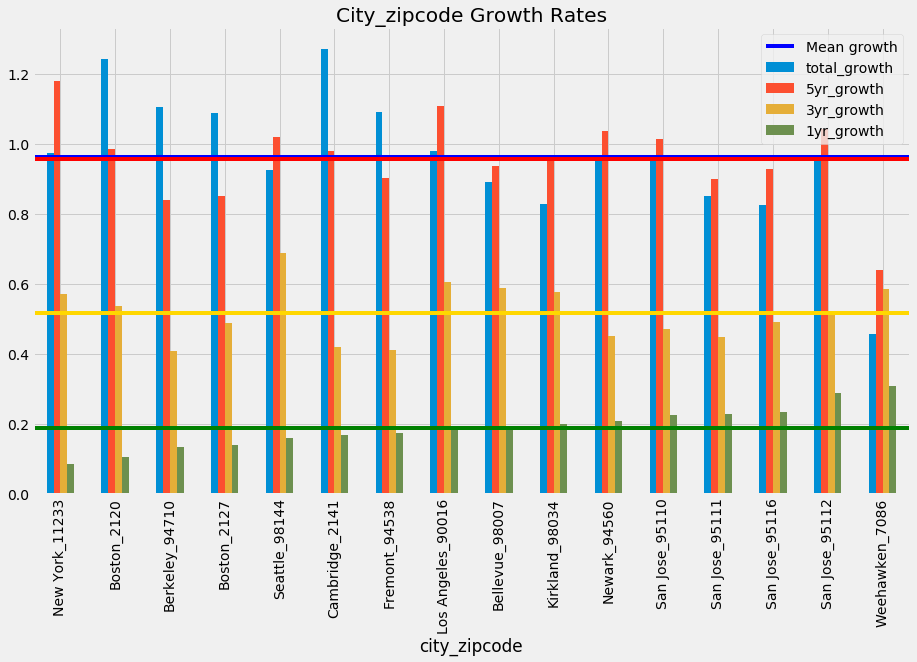

In [26]:
# this funtion takes a dataframe and creates a clustered bar chart with each growth period and orders
# it from left to right based on 1yr growth. 
# It also displays the mean growth for each period via a horizontal line. 
stacked_growth(top_high_cities);

**Observations:** 
* Weehawken appears to have experienced some of the most significant recent growth with 1yr and 3yr growth above average
* San Jose 95112 AND San Jose 95116 are both interesting with high recent growth and higher total growth

It's very interesting to see the growth rates next to each other, but to get a little deeper look let's also break them out into individual graphs. I've created another function to help do this, **graph_growth**.

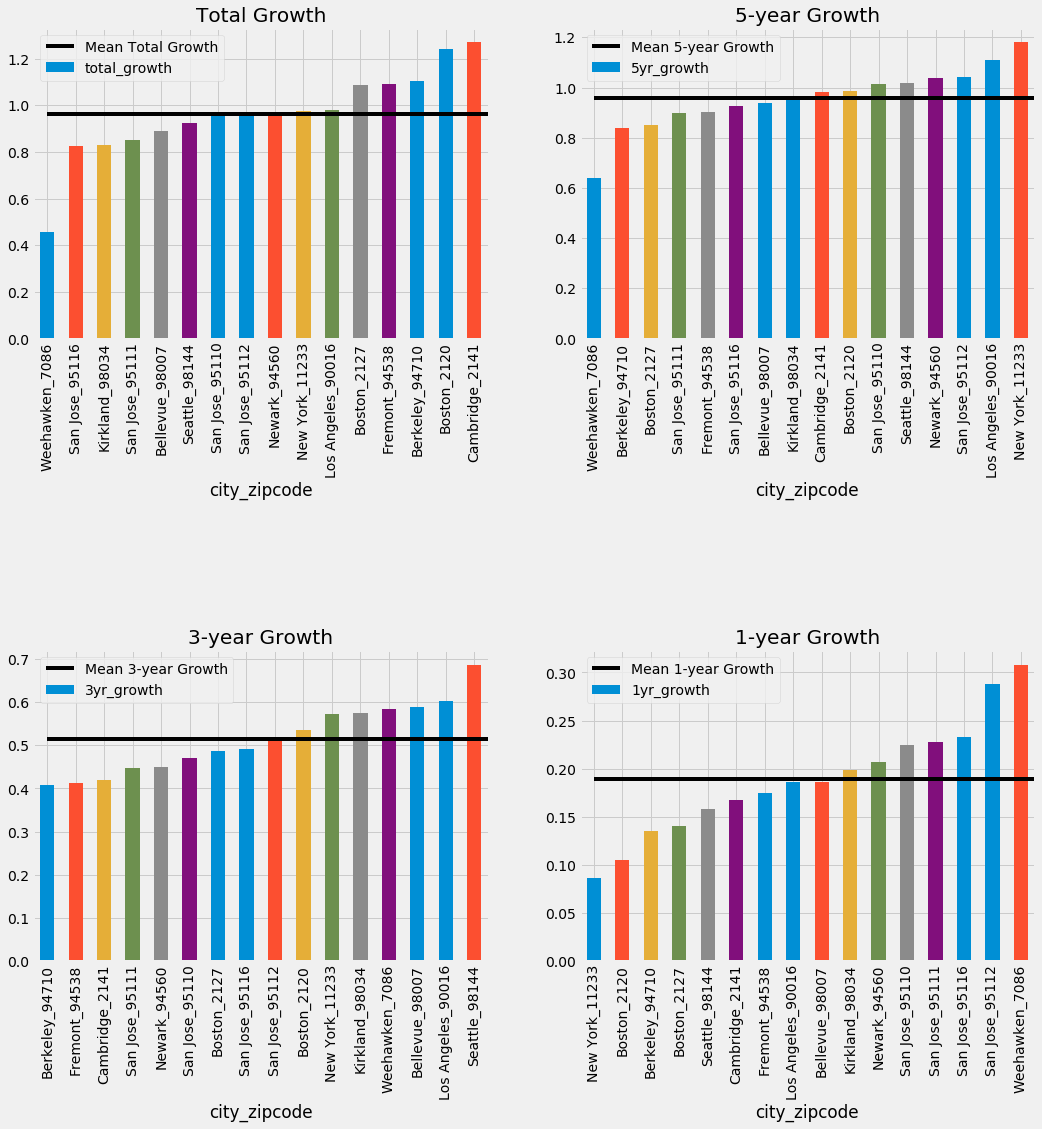

In [27]:
# takes a data frame and creates 4 subplots with bar charts organized from left to right, and 
# with a horizontal line for the mean
graph_growth(top_high_cities)

**Obervations:** 
* Cambridge, Boston_2120, and Berkeley have the greatest total growth, but slow down considerably in recent time frames
* Alternately, Weehawken and San Jose have lower total growth but appear to be speeding up. 
* If we recall from earlier, our national House Price Index indicated the national average growth over 3 years was about 20%, so we appear to be in good shape for each of the areas in consideration

#### Convert to Time Series 

Let's start to look at our top cities over time. To do this I have written a function, **get_time_series**, that will take our dataframe of cities and convert each unique city_zipcode row and convert it into a time series, and store it in a dictionary, setting the city_zipcode name as a key, and the time series as the value. 

Within the function, we also call two other functions, **YoY_change** and **YoY_rate_o_change**. These functions calculate the year-over-year percent change in price and the 3-month difference in the percent change to get an indication of directionality of the percent change. 

In [28]:
# convert rows to vertical time series for each city and store in a dictionary
# calculate the YoY % change in value and the 3mo difference in the % change
top_high_ts = get_time_series(top_high_cities)
top_high_ts['New York_11233'].head(13)

city_zipcode State     Metro CountyName     value  YoY_change  \
time                                                                          
2009-01-01  New York_11233    NY  New York      Kings  431700.0         NaN   
2009-02-01  New York_11233    NY  New York      Kings  423100.0         NaN   
2009-03-01  New York_11233    NY  New York      Kings  416900.0         NaN   
2009-04-01  New York_11233    NY  New York      Kings  413100.0         NaN   
2009-05-01  New York_11233    NY  New York      Kings  408300.0         NaN   
2009-06-01  New York_11233    NY  New York      Kings  400500.0         NaN   
2009-07-01  New York_11233    NY  New York      Kings  393500.0         NaN   
2009-08-01  New York_11233    NY  New York      Kings  386900.0         NaN   
2009-09-01  New York_11233    NY  New York      Kings  380800.0         NaN   
2009-10-01  New York_11233    NY  New York      Kings  376000.0         NaN   
2009-11-01  New York_11233    NY  New York      Kings  372700.0         NaN   
2009-12-01  New York_11233    NY  New York      Kings  372400.0         NaN   
2010-01-01  New York_11233    NY  New York      Kings  367800.0   -0.148019   

            YoY_rate_change  
time                         
2009-01-01              NaN  
2009-02-01              NaN  
2009-03-01              NaN  
2009-04-01              NaN  
2009-05-01              NaN  
2009-06-01              NaN  
2009-07-01              NaN  
2009-08-01              NaN  
2009-09-01              NaN  
2009-10-01              NaN  
2009-11-01              NaN  
2009-12-01              NaN  
2010-01-01              NaN

I thought it might also be interesting to see what the average YoY growth was for each city and compare, but it appears that this is very similar to total growth, which makes sense. But again, moving forward we'll weight recent growth more more heavily in our considerations. 

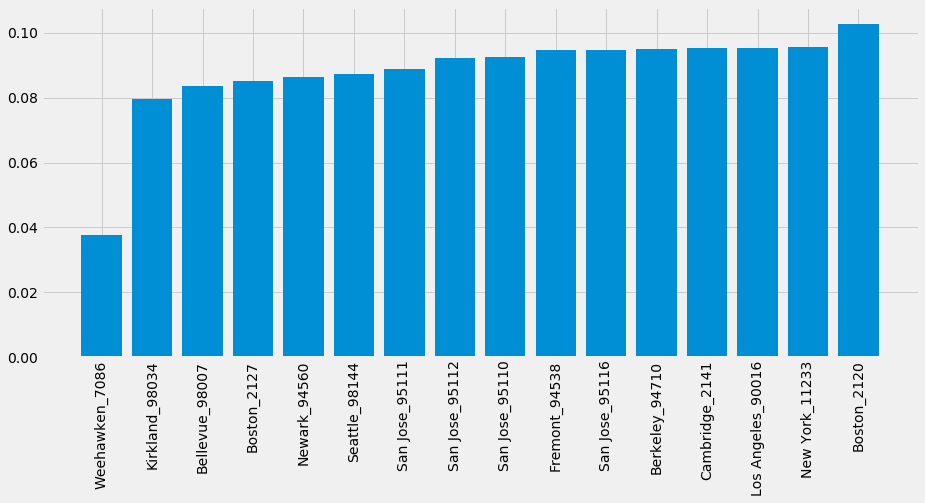

In [29]:
# average the YoY growth for each city and plot in a bar chart
plot_avg_YoY(top_high_ts)

#### Visualize value over time - high value areas

To see how values have moved over time for all of the cities in our high-value segment I wrote a function, **plot_time_series2**, that creates three time series plots for each city in a dictionary: total value, YoY change, and YoY rate of change

When we look at these we'll be looking for a few different things:
* are values moving up steadily
* is YoY change above zero, and is it moving upward or downward
* is YoY rate of change steady (close to zero), erratic, and increasing or decreasing

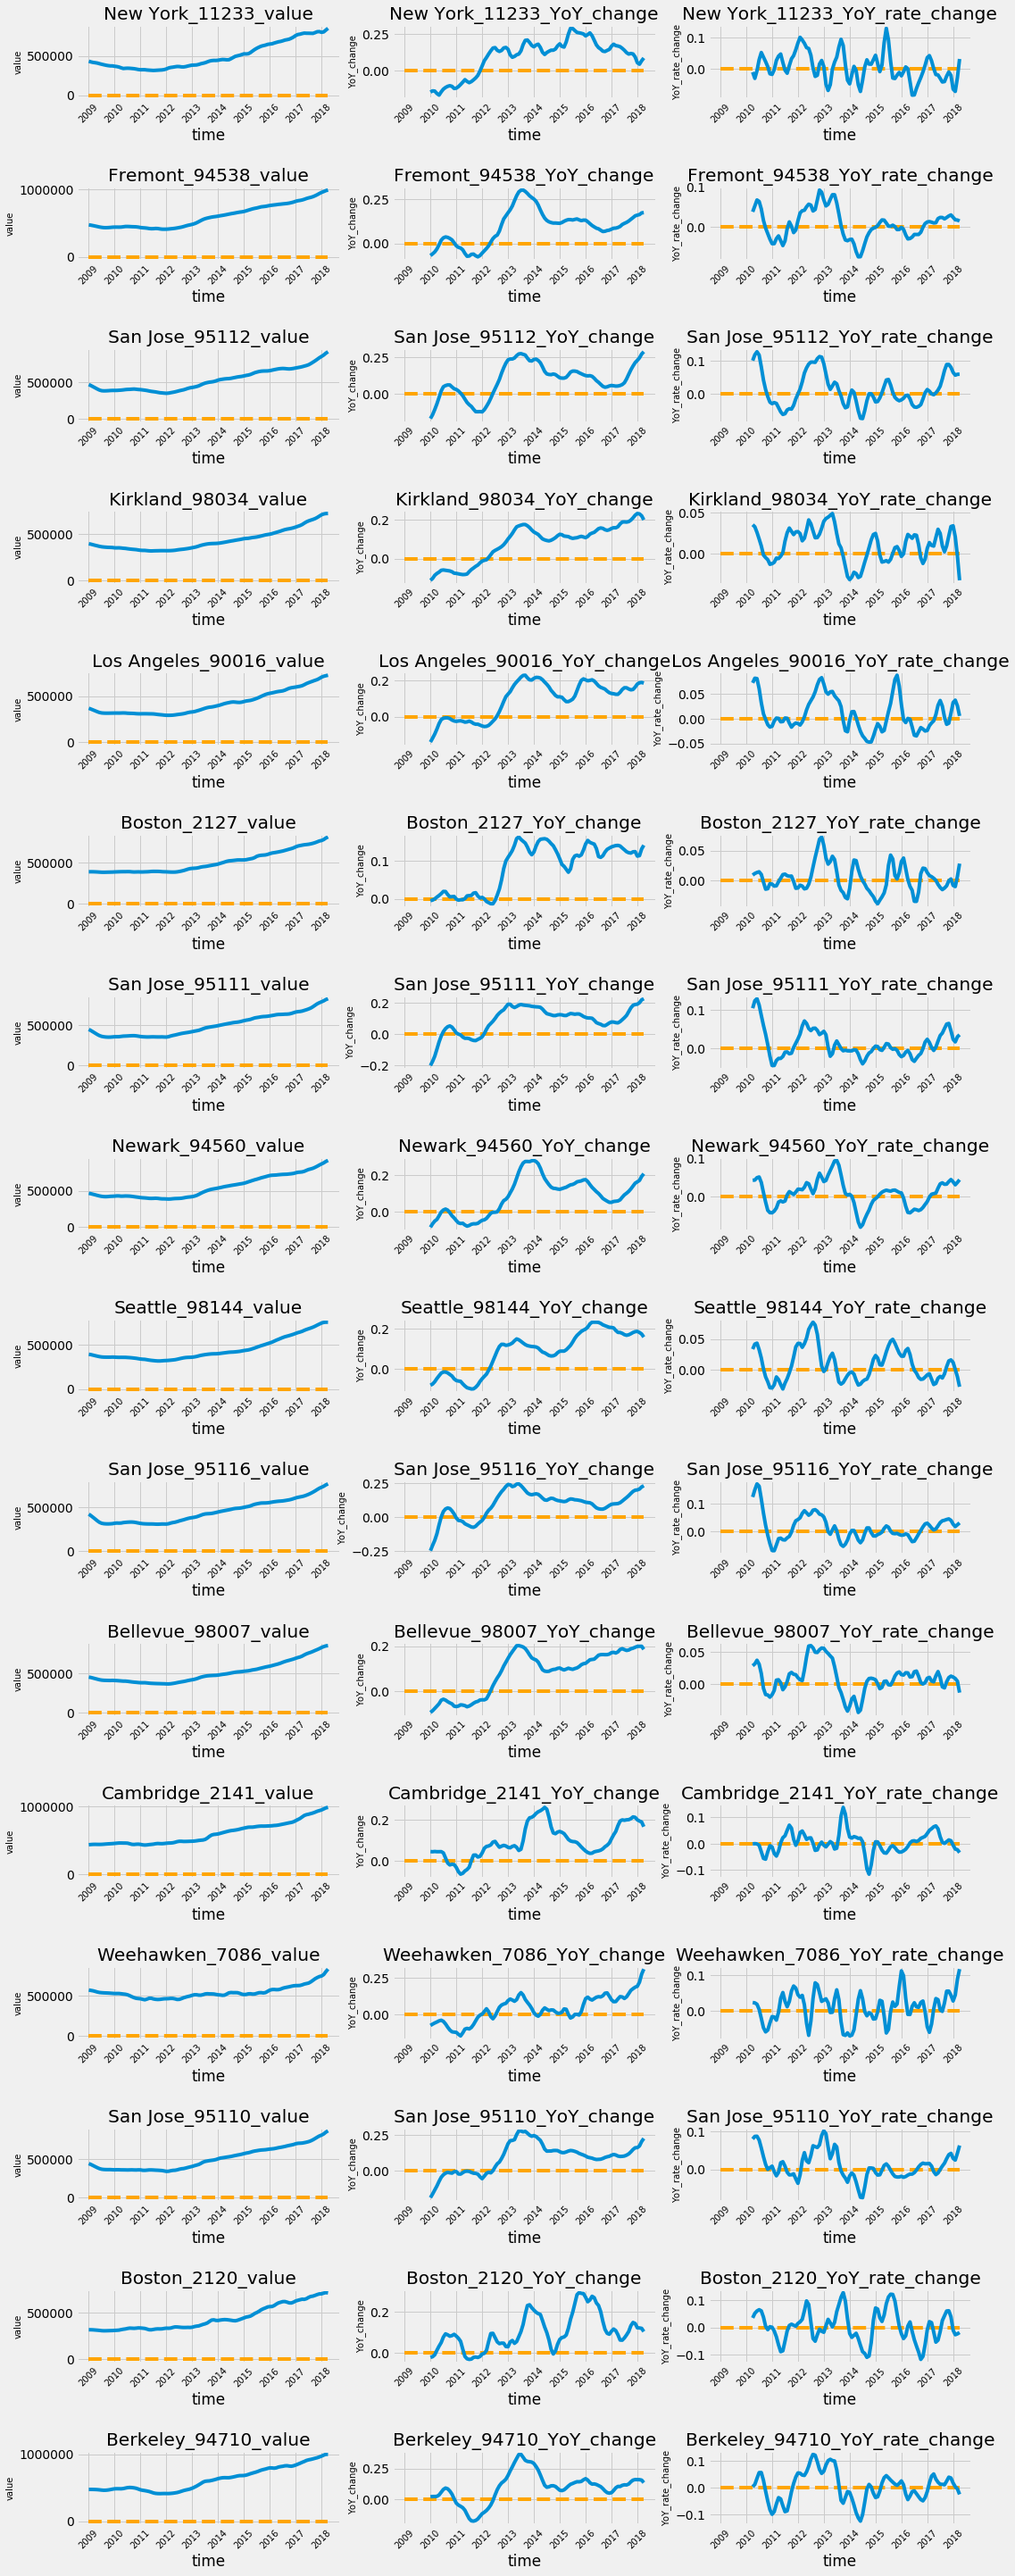

In [30]:
# plot value, YoY change, and YoY rate of change for each city_zipcode
plot_time_series2(top_high_ts)

**Selections for modeling:**
Based on observations from above, I think it will be most interesting to look at the following two areas more closely for modeling:
* San Jose_95116 - YoY change appears to be trending up and the YoY rate of change is consistent - this is our more conservative choice
* Weehawken_7086 - YoY change is spiking upward, with YoY rate of change accelerating as well - this is our more risky, but potentially higher short-term growth choice

**Pull data out for analysis**

In [31]:
# create time series for each target city with jsut the data we need to make our models
sj_ts = top_high_ts['San Jose_95116']['value']
wh_ts = top_high_ts['Weehawken_7086']['value']
display(sj_ts.head(3), wh_ts.head(3))

time
2009-01-01    418800.0
2009-02-01    400700.0
2009-03-01    381500.0
Name: value, dtype: float64

time
2009-01-01    574300.0
2009-02-01    569100.0
2009-03-01    564400.0
Name: value, dtype: float64

### Medium Cost City Analysis

In this section we'll repeat the above process for cities in our medium-value segment. Good thing we've created a number of functions we can use to easily reproduce the work above!

In [32]:
# determine which cities had top total, 5yr, 3yr, and 1yr growth
top_med_cities = top_growth_cities(med_cost_zipcodes)
print('Cities in our list: ', len(top_med_cities))
top_med_cities.city_zipcode

Cities in our list:  18


319            Union City_7087
660           Jersey City_7306
1379             Oakland_94605
1477             Oakland_94601
1681             Oakland_94606
1737          Jersey City_7307
1843              Denver_80205
1853            Richmond_94804
3096            Lakewood_80214
4058           Somerville_2145
4070             Seattle_98106
4678          Charleston_29403
5217              Denver_80207
5436             Seattle_98108
7354            Richmond_94805
13591          El Portal_95389
13708    Mountain Center_92561
14636          Tuftonboro_3853
Name: city_zipcode, dtype: object

**Observations:** We have 18 city_zipcodes in this set, suggesting even more variability of longer and shorter term growth. 

<Figure size 1008x576 with 0 Axes>

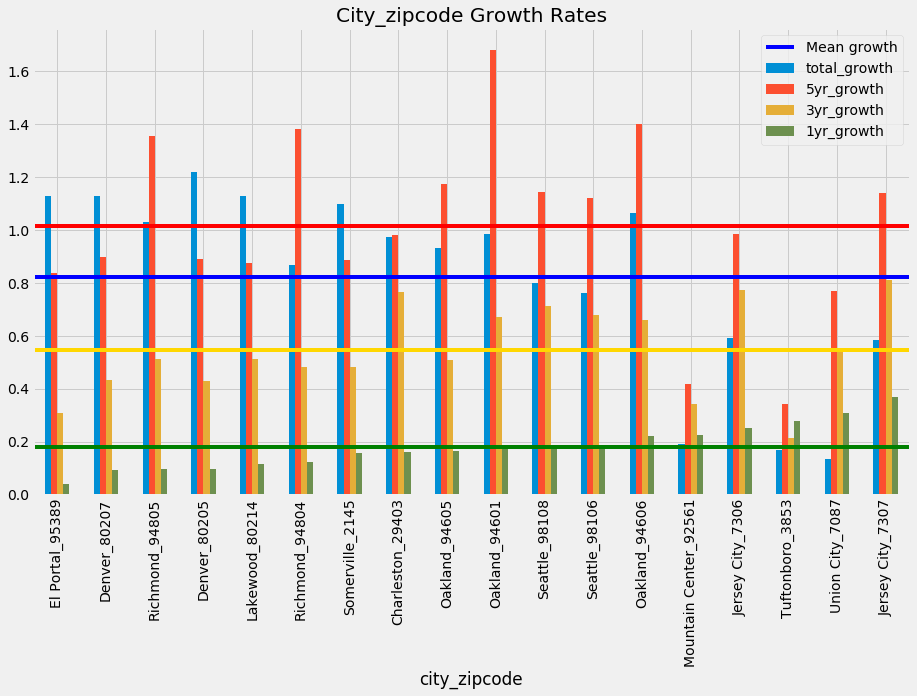

In [33]:
# create a clustered bar chart with each growth period for each city_zipcode and 
# display the mean growth for each period via a horizontal line. 
stacked_growth(top_med_cities)

**Observations:**
* This group is interesting because average 5 year growth is greater than total growth
* Jersey City 7307, Union City 7087, Jersey City 7306, and Oakland 94606 are all interesting with multiple periods above the average 

Let's breakout the subplots again. 

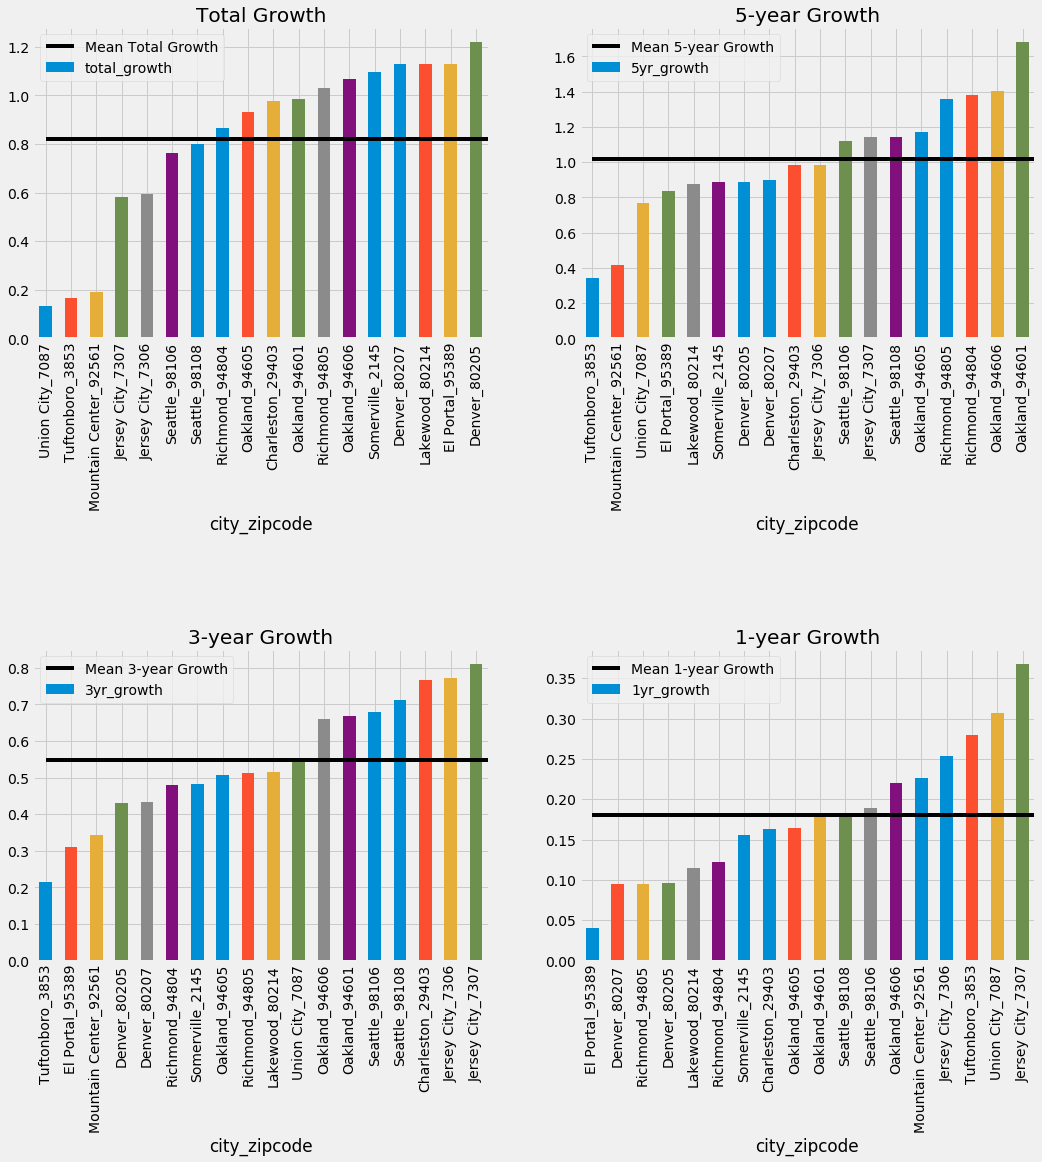

In [34]:
# create 4 subplots with bar charts organized from left to right, and 
# with a horizontal line for the mean
graph_growth(top_med_cities)

**Observations:**
* These are super interesting in that there are much bigger ranges in the highest and lowest rates in each category than we observed for the high-value areas
* Similar to before, many of the areas with the highest total growth have smaller more recent growth
* Jersey City, Union City, and Oakland still appear to be areas we want to focus on based on recent growth 

In [35]:
# convert rows to vertical time series for each city and store in a dictionary
# calculate the YoY % change in value and the 3mo difference in the % change
top_med_ts = get_time_series(top_med_cities)
top_med_ts['Union City_7087'].head(13)

city_zipcode State     Metro CountyName     value  YoY_change  \
time                                                                           
2009-01-01  Union City_7087    NJ  New York     Hudson  396300.0         NaN   
2009-02-01  Union City_7087    NJ  New York     Hudson  386000.0         NaN   
2009-03-01  Union City_7087    NJ  New York     Hudson  375900.0         NaN   
2009-04-01  Union City_7087    NJ  New York     Hudson  366300.0         NaN   
2009-05-01  Union City_7087    NJ  New York     Hudson  356200.0         NaN   
2009-06-01  Union City_7087    NJ  New York     Hudson  345600.0         NaN   
2009-07-01  Union City_7087    NJ  New York     Hudson  335900.0         NaN   
2009-08-01  Union City_7087    NJ  New York     Hudson  327500.0         NaN   
2009-09-01  Union City_7087    NJ  New York     Hudson  320800.0         NaN   
2009-10-01  Union City_7087    NJ  New York     Hudson  315800.0         NaN   
2009-11-01  Union City_7087    NJ  New York     Hudson  311500.0         NaN   
2009-12-01  Union City_7087    NJ  New York     Hudson  306400.0         NaN   
2010-01-01  Union City_7087    NJ  New York     Hudson  300000.0   -0.242998   

            YoY_rate_change  
time                         
2009-01-01              NaN  
2009-02-01              NaN  
2009-03-01              NaN  
2009-04-01              NaN  
2009-05-01              NaN  
2009-06-01              NaN  
2009-07-01              NaN  
2009-08-01              NaN  
2009-09-01              NaN  
2009-10-01              NaN  
2009-11-01              NaN  
2009-12-01              NaN  
2010-01-01              NaN

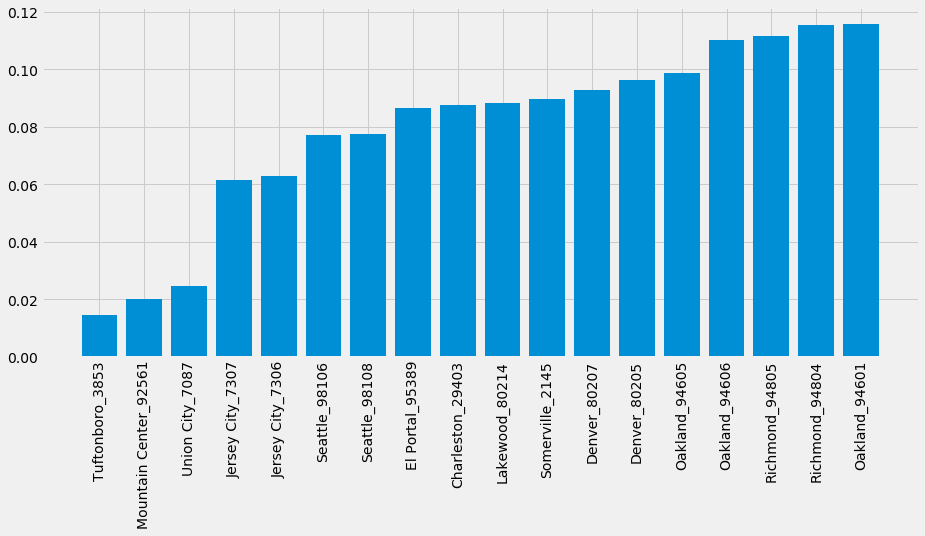

In [36]:
# average the YoY growth for each city and plot in a bar chart
plot_avg_YoY(top_med_ts)

**Observatons:** Different to what we saw previously, the top total growth citied are in the middle of this graph, perhaps suggesting more steady growth for them. Similar to how we saw that 5 year growth seems to be the biggest for this segment, those areas are further to the right in this graph. 

One insight may be that these areas took slightly longer to recover from the housing crises and may earlier in thier growth cycles than the high-value areas we've previously analyzed. 

Let's see how this data looks over time. 

#### Visualize value over time - medium value areas

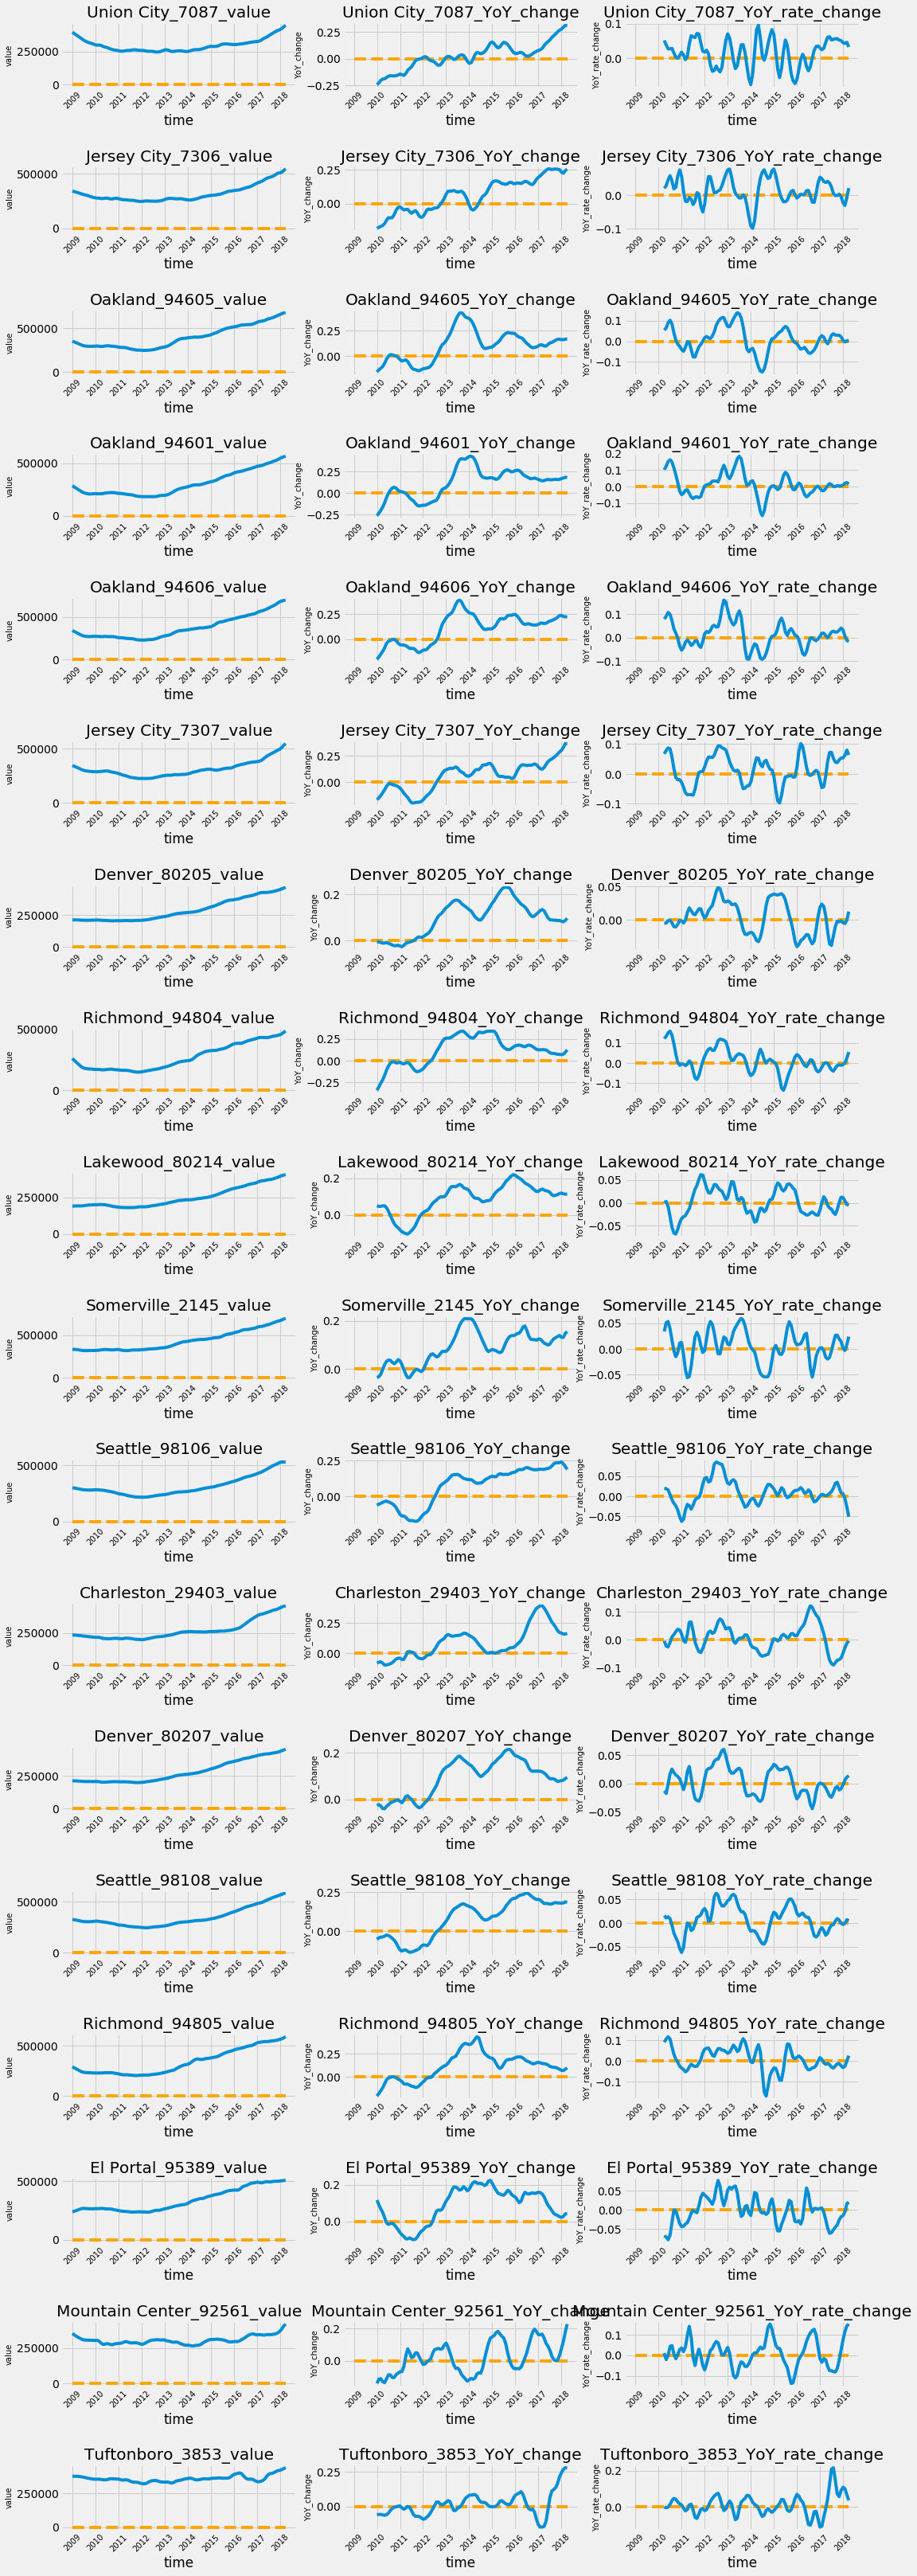

In [37]:
# plot value, YoY change, and YoY rate of change for each city_zipcode
plot_time_series2(top_med_ts)

**Selections for modeling:** For medium value areas I am interested in looking further into: 
- Union City_7087 - appears to have accelerating recent growth, more erratic and potentially slowing, so higher risk
- Jersey City_7306 - more sustained positive YoY  change with recent turn upward in rate of growth
- Oakland_94601 - flatter growth and rate of growth - lower risk of the of the three but still positive 

#### Pull out data for analysis

In [38]:
# create time series for each target city with jsut the data we need to make our models
uc_ts = top_med_ts['Union City_7087']
jc_ts = top_med_ts['Jersey City_7306']
ok_ts = top_med_ts['Oakland_94601']

### Lower Value Area Analysis

In this section we'll repeat our EDA process one more time for our lower value areas and select three more city_zipcodes to model in the following section.

In [39]:
# identify the zipcodes with the greatest total, 5yr, 3y, and 1yr growth and 
#create a dataframe of just those areas
top_low_cities = top_growth_cities(low_cost_zipcodes)
print('Cities in our list: ', len(top_low_cities))
top_low_cities.city_zipcode

Cities in our list:  19


466         Philadelphia_19134
610               Denver_80219
1239             Vallejo_94590
1821           Charlotte_28208
2155              Denver_80204
2347        Jacksonville_32205
2452           Williston_58801
2470              Aurora_80010
2627          Lake Worth_33460
2661    Saint Petersburg_33705
3188            Palm Bay_32905
3285             Reading_19601
3464               Orange_7050
3540               Newark_7103
4211               Newark_7106
5830             Redford_48240
6105           Nashville_37210
6563          Pittsburgh_15201
6896            Wildwood_34785
Name: city_zipcode, dtype: object

**Observations:** We have 19 different areas this time, showing that we have the most variability yet. This is perhaps not surprising due to the fact that the vast majority of cities fell into this segment

<Figure size 1008x576 with 0 Axes>

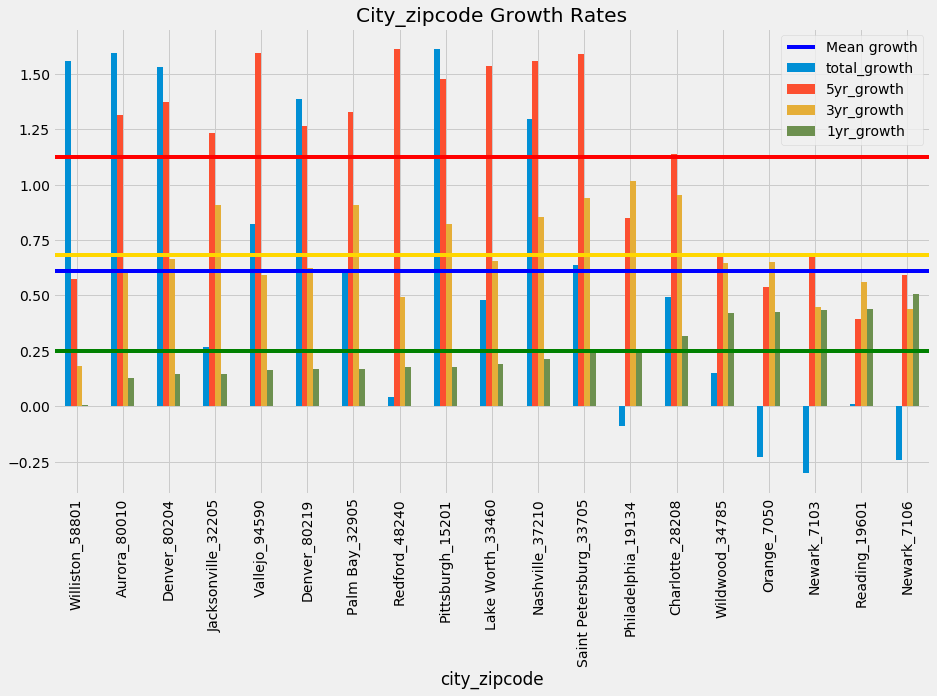

In [40]:
# create a clustered bar chart with each growth period for each city_zipcode and 
# display the mean growth for each period via a horizontal line. 
stacked_growth(top_low_cities)

**Observations:** 
* There is some really interesting stuff in this group. For the first time we see some areas with a negative total growth for the time observed. Average 3 year growth in this segment is also greater than total growth! 
* It's interesting that some of the areas with negative total growth are also the ones with the greatest recent growth

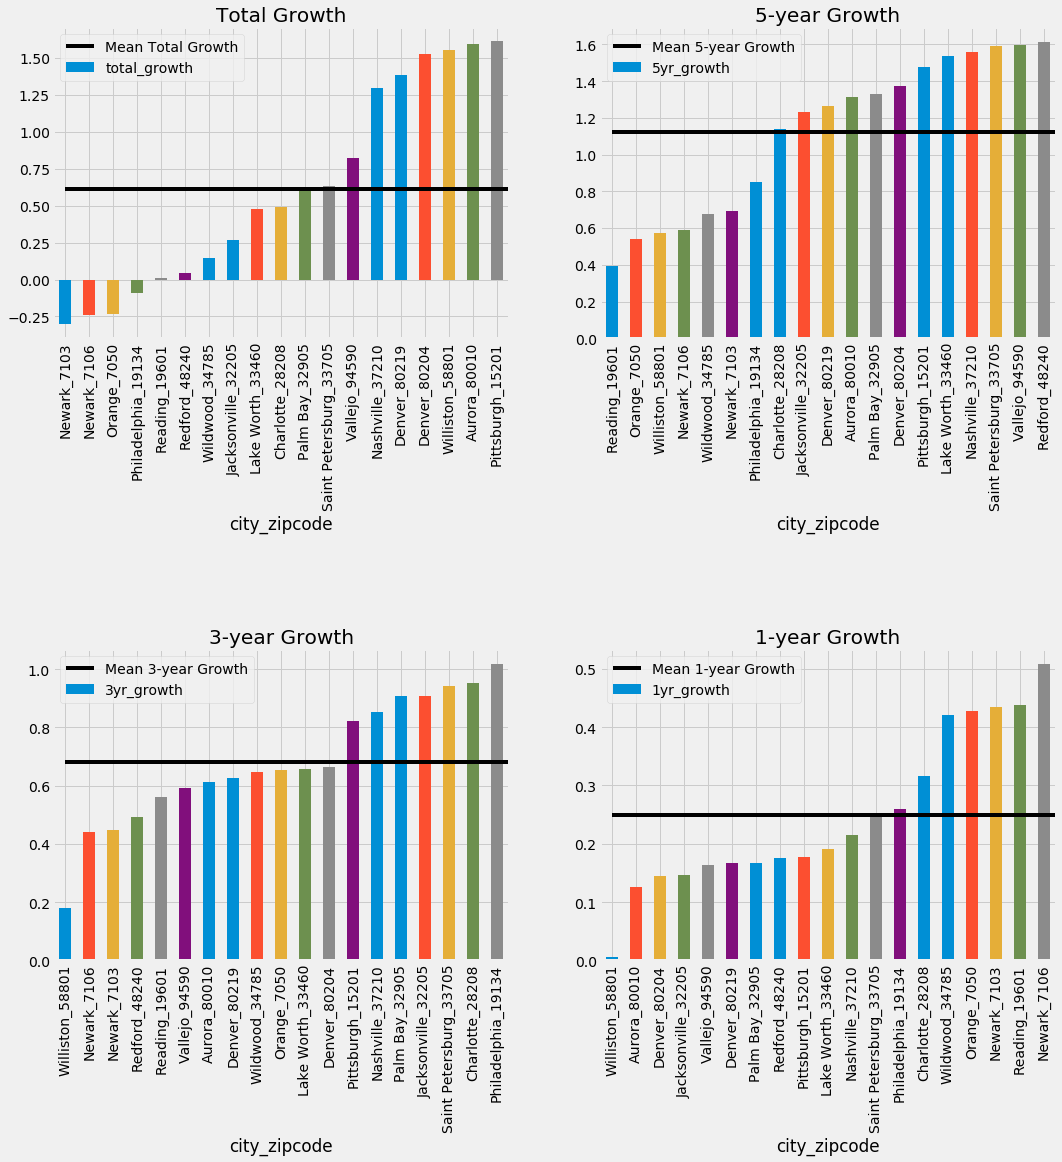

In [41]:
# create 4 subplots with bar charts organized from left to right, and 
# with a horizontal line for the mean
graph_growth(top_low_cities)

In [42]:
# convert rows to vertical time series for each city and store in a dictionary
# calculate the YoY % change in value and the 3mo difference in the % change
top_low_ts = get_time_series(top_low_cities)
top_low_ts['Philadelphia_19134'].head(13)

city_zipcode State         Metro    CountyName    value  \
time                                                                        
2009-01-01  Philadelphia_19134    PA  Philadelphia  Philadelphia  51100.0   
2009-02-01  Philadelphia_19134    PA  Philadelphia  Philadelphia  50400.0   
2009-03-01  Philadelphia_19134    PA  Philadelphia  Philadelphia  49900.0   
2009-04-01  Philadelphia_19134    PA  Philadelphia  Philadelphia  49500.0   
2009-05-01  Philadelphia_19134    PA  Philadelphia  Philadelphia  48800.0   
2009-06-01  Philadelphia_19134    PA  Philadelphia  Philadelphia  48100.0   
2009-07-01  Philadelphia_19134    PA  Philadelphia  Philadelphia  47200.0   
2009-08-01  Philadelphia_19134    PA  Philadelphia  Philadelphia  46500.0   
2009-09-01  Philadelphia_19134    PA  Philadelphia  Philadelphia  46100.0   
2009-10-01  Philadelphia_19134    PA  Philadelphia  Philadelphia  46100.0   
2009-11-01  Philadelphia_19134    PA  Philadelphia  Philadelphia  46000.0   
2009-12-01  Philadelphia_19134    PA  Philadelphia  Philadelphia  45900.0   
2010-01-01  Philadelphia_19134    PA  Philadelphia  Philadelphia  45700.0   

            YoY_change  YoY_rate_change  
time                                     
2009-01-01         NaN              NaN  
2009-02-01         NaN              NaN  
2009-03-01         NaN              NaN  
2009-04-01         NaN              NaN  
2009-05-01         NaN              NaN  
2009-06-01         NaN              NaN  
2009-07-01         NaN              NaN  
2009-08-01         NaN              NaN  
2009-09-01         NaN              NaN  
2009-10-01         NaN              NaN  
2009-11-01         NaN              NaN  
2009-12-01         NaN              NaN  
2010-01-01   -0.105675              NaN

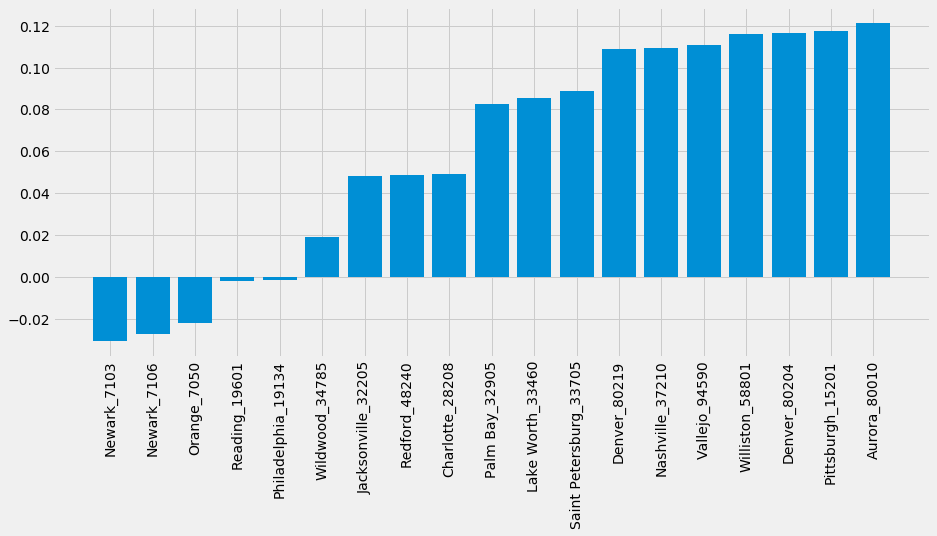

In [43]:
# average the YoY growth for each city and plot in a bar chart
plot_avg_YoY(top_low_ts)

#### Visualize value over time - lower value areas

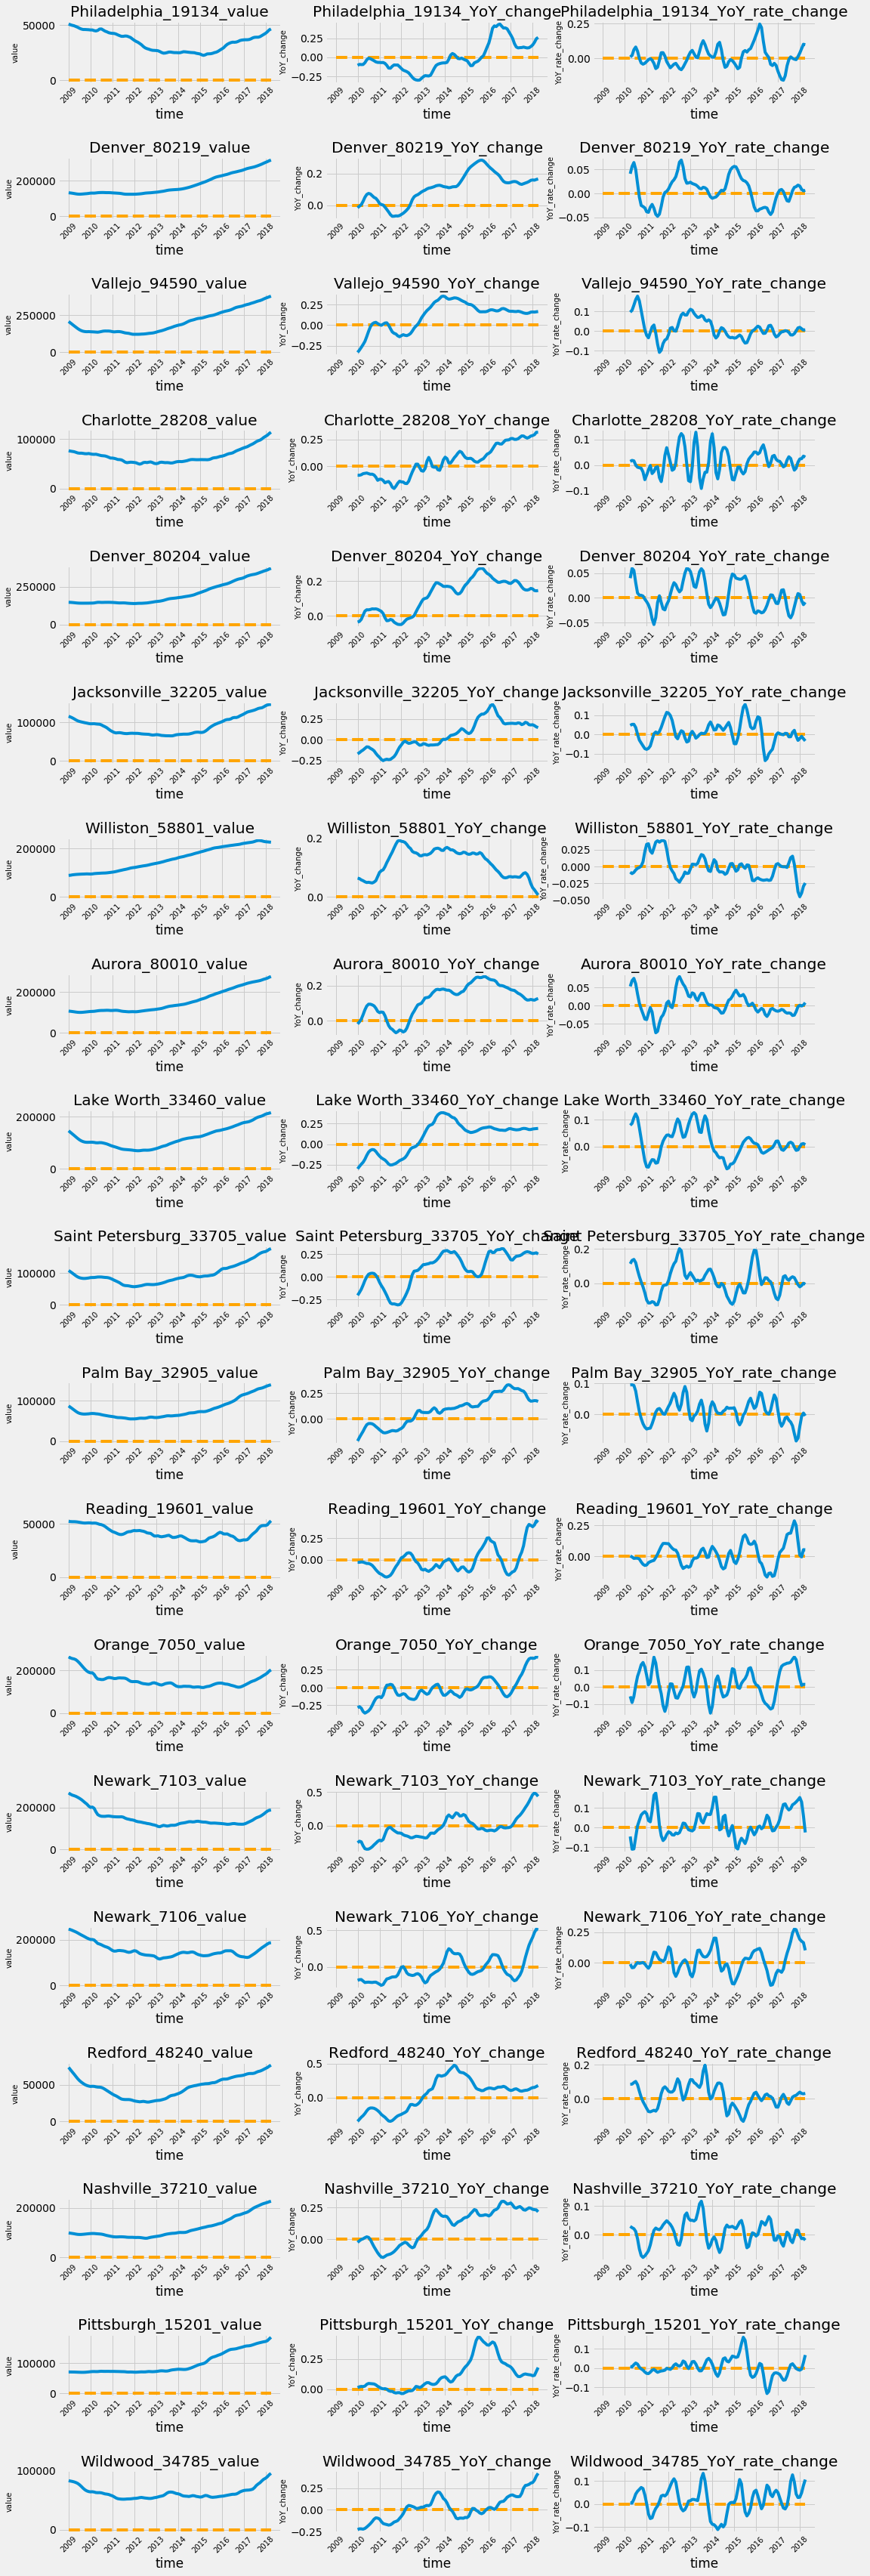

In [44]:
# plot value, YoY change, and YoY rate of change for each city_zipcode
plot_time_series2(top_low_ts)

**Selections for modeling:** For our lower value areas we will take a more conservative approach and aim for areas that have had the most consistent growth, which appear to be: 
- Vallejo 94590
- Aurora 80010
- Lake Worth 33460

#### Pull out data for analysis

In [45]:
# create time series for each target city with jsut the data we need to make our models
va_ts = top_low_ts['Vallejo_94590']
au_ts = top_low_ts['Aurora_80010']
lw_ts = top_low_ts['Lake Worth_33460']

# Modeling

In this section we will work through each segment of value areas again as we did before, but now building SARIMA models for each area we've chosen, with the ultimate goal of choosing 1 high value, 2 medium value, and 2 lower value areas to invest in. 

We will use a few different processes to experiment with stationarity and parameter selection, using methods we were taught in class as well as methods I have decided to incorporate on my own (e.g. grid search). 

SARIMA is an approach for modeling univariate time series data that may have a trend or seasonality. The model takes multiple parameters that I understand can be very dependent on deep domain knowledge (which I hope to grow), but we've learned methods for iterating through parameters that may help. 

Despite the fact that SARIMA is designed to deal with non-stationary data, for the sake of learning I have tried a few things out in the section below that I think are fun.

Modeling for each zipcode will follow the following rough outline: 
- Check for stationarity (understanding this isn't entirely necessary)
    - For the first model I will do some transformations for learning purposes
- Inspect Autocorrelation Function and Partial Autocorrelation Function
- Identify optimal model parameters 
- Fit model and inspect diagnostics
- Plot model and forecast
- Check future values and choose final city_zipcodes

## High Cost Models

For our first city we will try out a few different things just to see how they work. 

In this section we will be looking at: 
- San Jose_95116
- Weehawken_7086

### San Jose Modeling 

Let's first check to the stationarity of our data to see if we can see a consistent mean and variance. To do this I have made the function **stationarity_check** that accepts a time series, plots it, plots the rolling mean and variance, and conducts an advance Dickey-Fuller test for stationarity. 

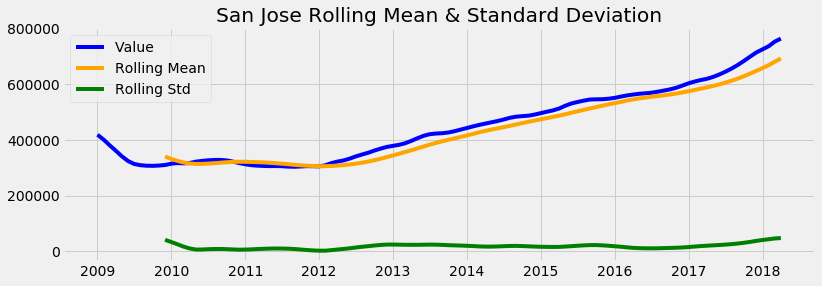

Results of Dickey-Fuller Test:
Test Statistic                   1.681359
p-value                          0.998082
#Lags Used                       9.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


In [46]:
# plot time series, rolling mean, rolling variance, and print results of an adfuller test
stationarity_check(sj_ts, title='San Jose')

**Observations:** It looks like our data is not quite stationary, the mean increases over time and the adfuller p-value is very high.

Let's see if there are some transformations we can do to make our data more stationary. 

To experiment with transformations for stationarity I made the **all_stationarity** function to iterate through 54 different transformations (log, sqrt, rolling mean, weighted rolling mean, diff) and variations of those and return combinations that have an adfuller score less than or equal to .05. 

When considering these, to avoid over-fitting I would start with the least transformed (or greatest acceptable p-value).

In [47]:
# iterate through possible transformations to identify ways to increase the stationarity of our time series
all_stationarity(sj_ts)

[('Original_minus_roll_mean_3:', 0.011906995783480336),
 ('Original_minus_roll_mean_diff_3:', 0.011906995783480336),
 ('Original_minus_w_roll_mean_diff_1:', 0.0010985119914647705),
 ('Original_minus_w_roll_mean_diff_2:', 0.0018571066453465187),
 ('Original_minus_w_roll_mean_diff_3:', 0.0031490884462736838),
 ('Original_minus_w_roll_mean_diff_4:', 0.0050434778053620845)]

[('Log_minus_w_roll_mean_diff_1:', 0.0005513808944027823),
 ('Log_minus_w_roll_mean_diff_2:', 0.000884196526851861),
 ('Log_minus_w_roll_mean_diff_3:', 0.001514717051850286),
 ('Log_minus_w_roll_mean_diff_4:', 0.0025366429429752872)]

[('Sqrt_minus_w_roll_mean_diff_1:', 0.0006960782074679233),
 ('Sqrt_minus_w_roll_mean_diff_2:', 0.0011436876371370313),
 ('Sqrt_minus_w_roll_mean_diff_3:', 0.001937833808796243),
 ('Sqrt_minus_w_roll_mean_diff_4:', 0.003157323443438213)]

**Observations:** It looks like there are a number of ways we could transform the data. To preserve the original data as much as possible we can start with simpler transformations and try a few more increasingly complex methods. 

In [48]:
# transform the sj_ts time series with the methods previously identified 
sj_roll_3 = subtract_rollmean(ts=sj_ts, window=3).dropna()
sj_log_w_roll_2_diff = subtract_w_rollmean(ts=np.log(sj_ts), halflife=2).diff().dropna()
sj_sqrt_w_roll_2_diff = subtract_w_rollmean(ts=np.sqrt(sj_ts), halflife=2).diff().dropna()

# sj_series = [sj_ts, sj_roll_3, sj_log_w_roll_2_diff, sj_sqrt_w_roll_2_diff]

Let's see how these look.

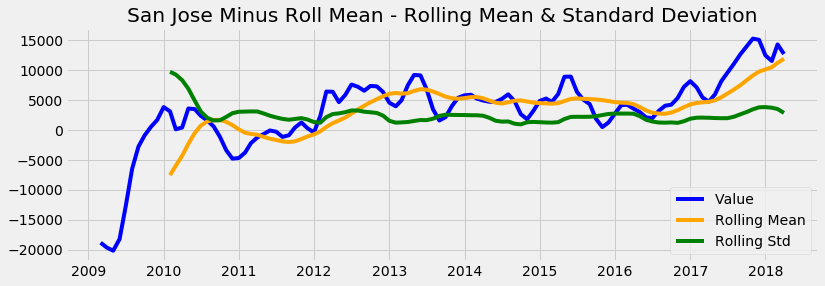

Results of Dickey-Fuller Test:
Test Statistic                  -3.373203
p-value                          0.011907
#Lags Used                       4.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


In [49]:
# plot and check stationarity with adfulller 
stationarity_check(sj_roll_3, title='San Jose Minus Roll Mean -')

**Observations:** Mean is slightly increasing, std fairly flat, critical value is lower at the 5% and 10% level

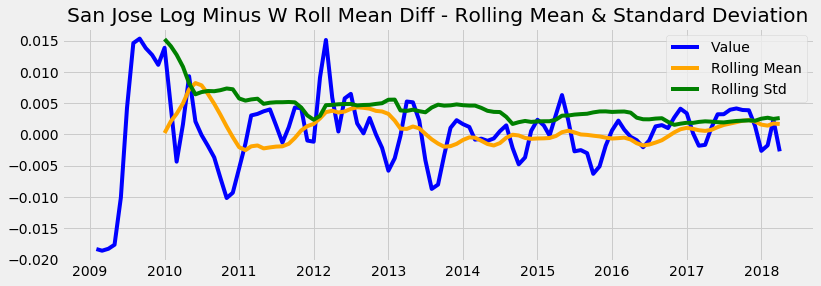

Results of Dickey-Fuller Test:
Test Statistic                  -4.123865
p-value                          0.000884
#Lags Used                       8.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


In [50]:
# plot and check stationarity with adfulller 
stationarity_check(ts=sj_log_w_roll_2_diff, title='San Jose Log Minus W Roll Mean Diff -')

**Observations:** Mean is much flatter, very low p-value and low critical value , reject null 

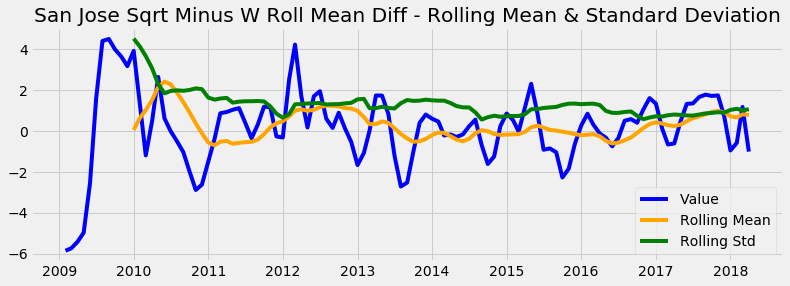

Results of Dickey-Fuller Test:
Test Statistic                  -4.056086
p-value                          0.001144
#Lags Used                       8.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


In [51]:
stationarity_check(ts=sj_sqrt_w_roll_2_diff, title='San Jose Sqrt Minus W Roll Mean Diff -')

**Observations:** Mean is relatively flat, very low p-value and low critical value , reject null 

At this point it appear that if we wanted to increase the stationarity of our time series we would have done so and much as we could, and we could move forward with an ARMA or ARIMA model. 

Below we'll check for autocorrelation and partial autocorrelation with the original time series to see what it tells us, and then model both the transformed and the original data with SARIMAX and see how good of a fit we can get. 

### ACF and PACF

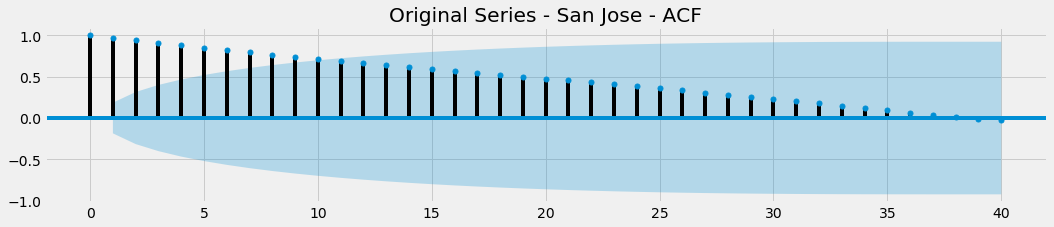

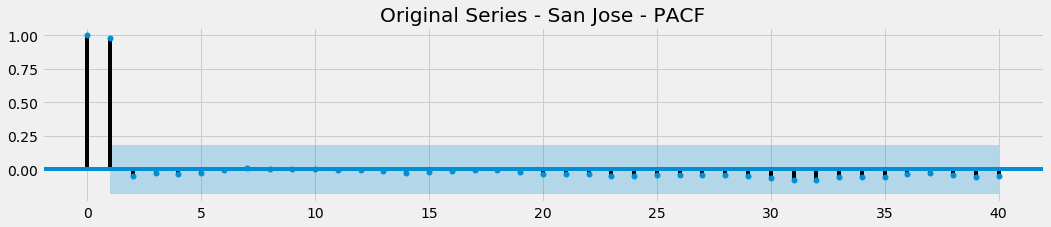

In [52]:
# plot ACF and PACF for the original time series
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(sj_ts.dropna(),ax=ax, lags=40)
plt.title('Original Series - San Jose - ACF');


fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(sj_ts.dropna(),ax=ax, lags=40)
plt.title('Original Series - San Jose - PACF');

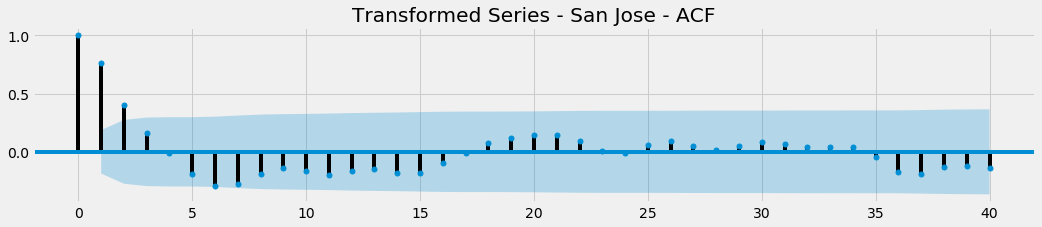

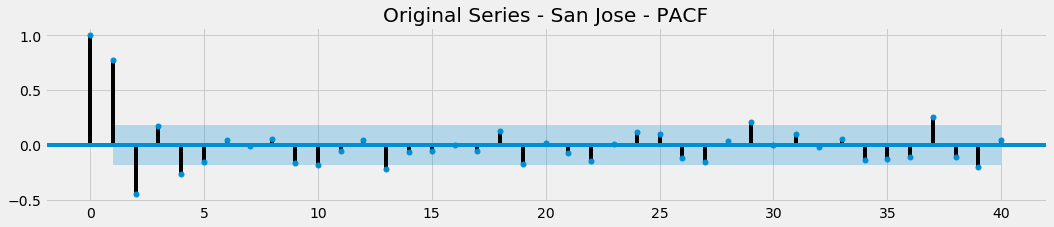

In [53]:
# plot ACF and PACF for the transformed time series
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(sj_log_w_roll_2_diff.dropna(),ax=ax, lags=40)
plt.title('Transformed Series - San Jose - ACF');

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(sj_log_w_roll_2_diff.dropna(),ax=ax, lags=40)
plt.title('Original Series - San Jose - PACF');

**Observations:** In the first example we see autocorrelation all the way out to the 8th or 9th lag, but the transformed model gets much tighter

### SARIMA - San Jose

The observations in our ACF and PACF plots above could be used to choose our parameters and likely be fairly accurate. For the transformed data we see significance at the 1st lag for ACF and PACF. However we also have the iterator we built in this module to help us choose parameters. 

I've put the iterator inside the function **SARIMA_iterator**, which takes a times series and an argument for max order range (default is 2). Let's try that first on our transformed data to see what we get.  

In [54]:
#iterate through SARIMA parameters with a max order of 1 
SARIMA_iterator(sj_log_w_roll_2_diff)

pdq         (1, 0, 1)
pdqs    (0, 0, 0, 12)
aic          -958.094
Name: 40, dtype: object

**Observations:** The iterator has found the lowest AIC score with the parameters indicated above. Interestingly it has no adjustment for seasonality. Let's fit that model and see what we get. 

In [55]:
#establish and fit a SARIMA model
SARIMA_MODEL = sm.tsa.statespace.SARIMAX(sj_log_w_roll_2_diff,
                                         order =(1,0,1),
                                         seasonal_order=(0,0,0,12),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
output = SARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6271      0.057     11.009      0.000       0.515       0.739
ma.L1          0.6677      0.074      9.022      0.000       0.523       0.813
sigma2      8.362e-06   9.74e-07      8.581      0.000    6.45e-06    1.03e-05


**Observations:** With very low p-values and reasonable coefficients it appears that these features contribute significantly to the model. Let's check diagnostics.

#### Plot Model Diagnostics - San Jose 1

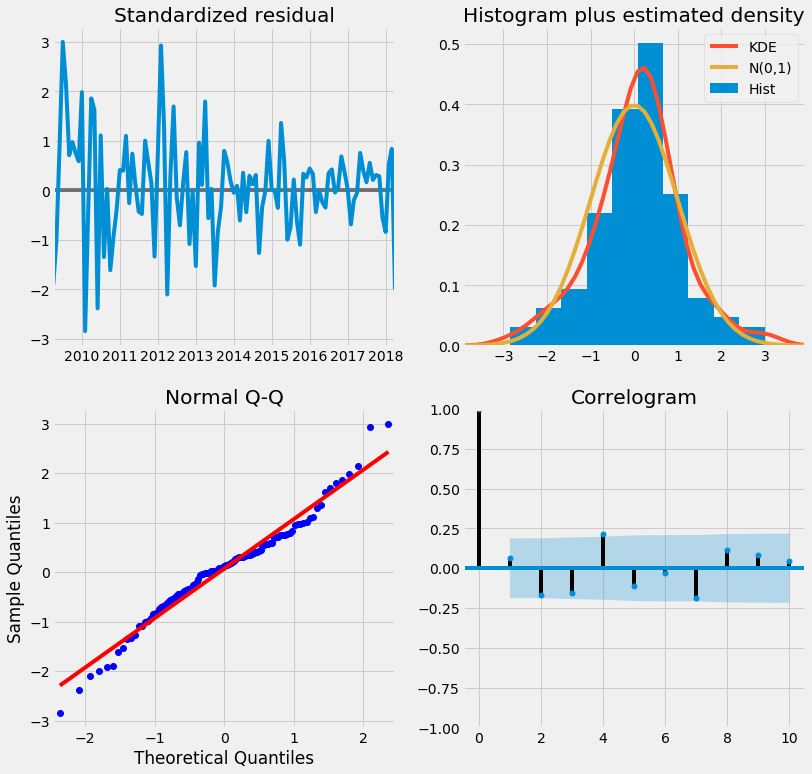

In [56]:
# plot model diagnostics
output.plot_diagnostics(figsize=(12,12));

**Observations:** Here we are checking to see that none of our model assumptions have been violated: 
- It appears there may be some heteroskedasticity among our residuals 
- The histogram shows KDE following N(0,1) fairly closely, indicating normality among residuals
- QQ plot shows a mostly linear trend but with somewhat of an s-curve, but mostly indicate a normal distribution of residuals
- there appears to be low correlation with lagged values (maybe popping out a little at 4 there) 

With this is seems that we have a relatively well fit model. Let's plot it and see how it looks.

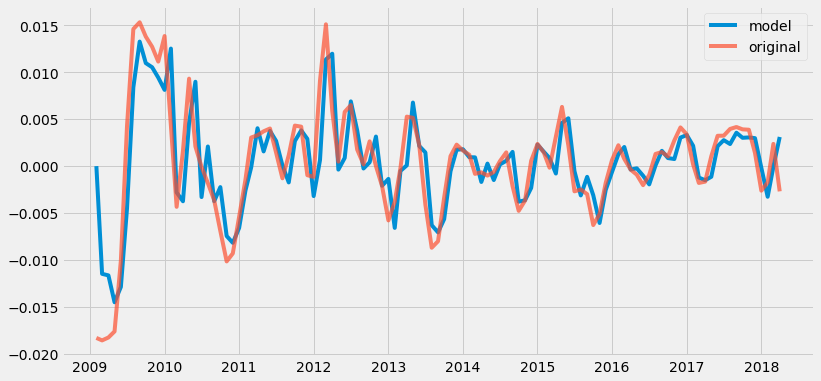

In [57]:
# plot the predicted values over the transformed time series
fig = plt.figure(figsize=(12,6))

plt.plot(output.predict(), label='model')
plt.plot(sj_log_w_roll_2_diff, label='original', alpha=.7)
plt.legend()

Looks to fit very closely, let's see how it looks if we forecast future values

In [58]:
# Get forecast 36 steps ahead in future
prediction = output.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int(alpha=.05)


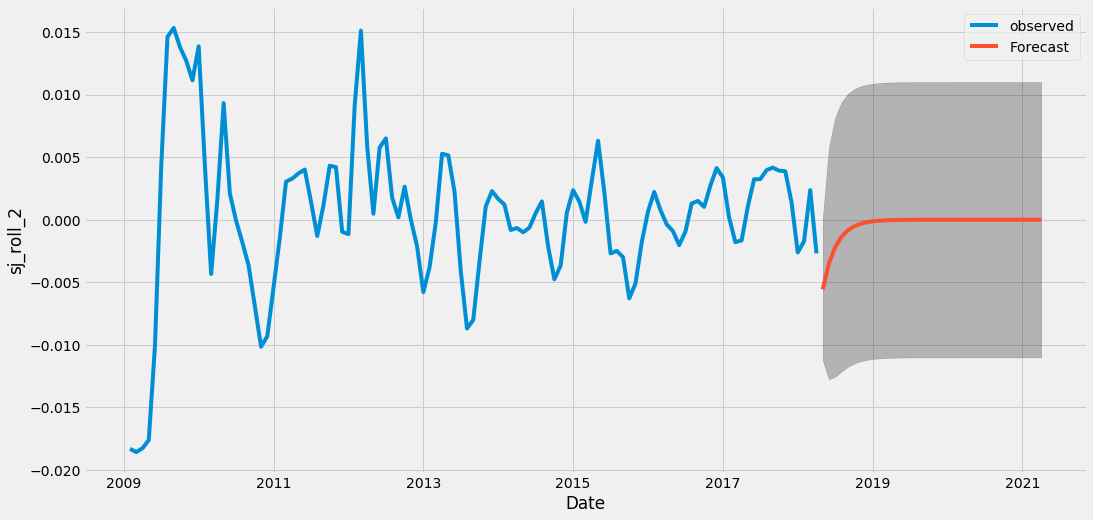

In [59]:
# plot transformed data and forecasted mean and confidence interval 
ax = sj_log_w_roll_2_diff.plot(label='observed', figsize=(16, 8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('sj_roll_2')

plt.legend()
plt.show()

**Observations:** The model looks like it has a fairly good prediction at with the 95% confidence interval, but it's tough to draw real insights from because the data is transformed. 

Since SARIMA can handle data with some trend and seasonality, let's see how good of a model we can get with the original data. 

To make this process more repeatable I have again made a number of functions to help us do this a little easier. 

#### SJ Model 2 - Original Data

Let's first iterate through some parameters

In [60]:
# iterate through possible SARIMA parameters for origical data, max order of 1
SARIMA_iterator(sj_ts)

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           1528.13
Name: 63, dtype: object

**Observations:** This time it looks like we have a higher AIC and more parameters to use, biggest difference appears to be accounting for seasonality this time. 

Let's fit a model. I've built a couple simple functions to do this with, **SARIMA_modeler** and **model_details**.

Model coefficients:  ar.L1       7.578196e-01
ma.L1       7.747945e-01
ar.S.L12    1.128344e-01
ma.S.L12   -1.862334e-01
sigma2      3.757958e+06
dtype: float64

 Model p_values:  ar.L1       1.376194e-22
ma.L1       1.240113e-24
ar.S.L12    7.322945e-06
ma.S.L12    3.572950e-04
sigma2      0.000000e+00
dtype: float64

 Model AIC:  1528.1302835906174


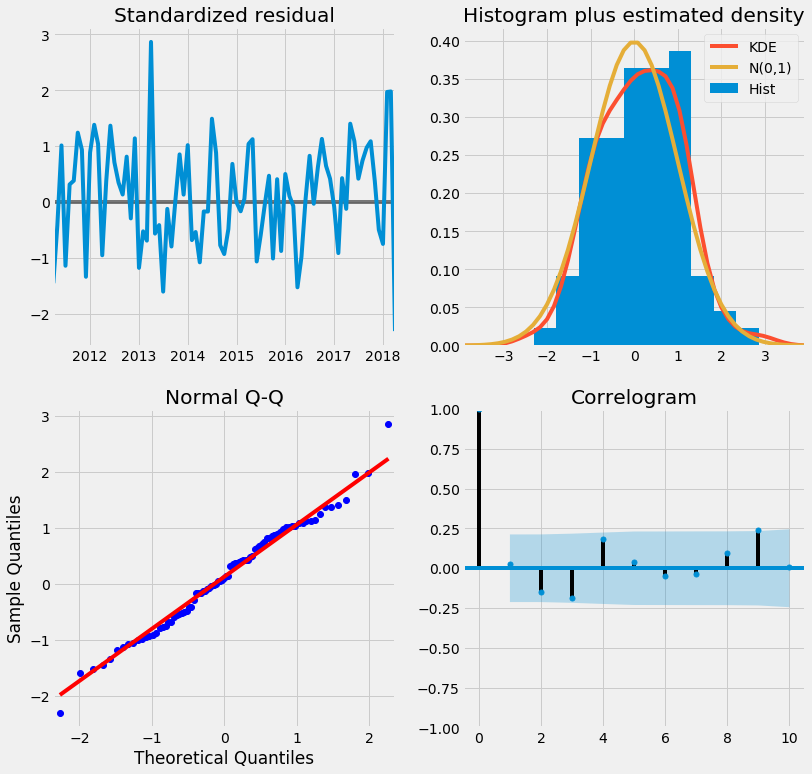

In [61]:
# fit a model to the original time series with the above parameters
sj_model2 = SARIMA_modeler(ts=sj_ts, order=(1,1,1), s_order=(1,1,1,12), trend=None)

# display the model details and diagnostics
model_details(sj_model2)

**Observations:** Even though we have a higher AIC score, a number of our other diagnostics look good:
- coefficients and p-values all appear significant
- residuals appear to be normally distributed, and with low correlation 

Let's plot this and see how it looks. I have another function for this **plot_model** and **plot_forecast_model**

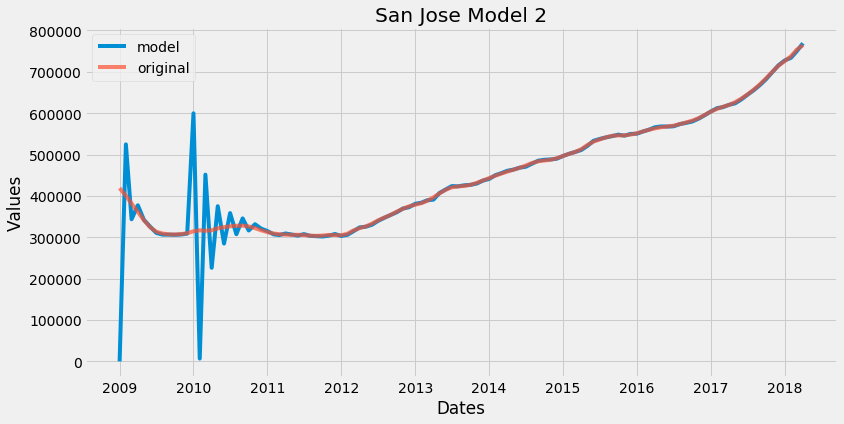

In [62]:
# plot the original time series and the model predictions
plot_model(sj_ts, sj_model2, title='San Jose Model 2')

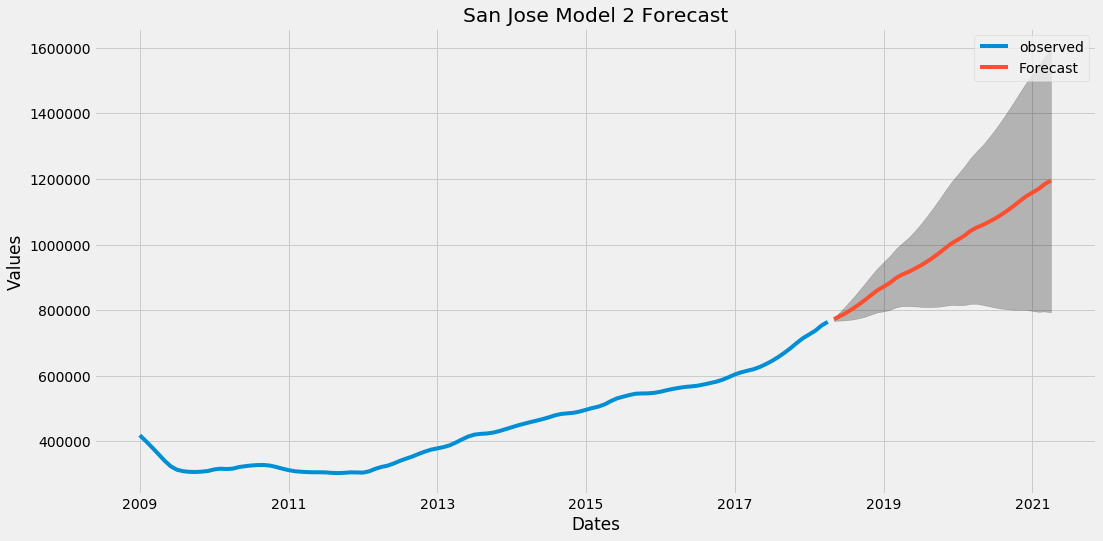

In [63]:
# forecast future values out 36 steps and plot mean and confidence interval
plot_forcast_model(sj_ts, sj_model2, title='San Jose Model 2 Forecast')

**Observations:** This is much more readable, and looks to be a good range of prediction, from flat growth to doubling in value over 3 years

Despite this good outcome I want to try one more method I've learned, **grid search**. 

In another file the I created based on this article:

**How to Grid Search SARIMA Hyperparameters for Time Series Forecasting**
https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

I have a method that iterates through 2,592 different combinations of parameters to identify the model with the lowest mean squared error, based on a train-test split that I have set at a default for 12 values (of our 112). I'll try it below with 24 values as well to try to avoid over-fitting, but let's try below and see if we can see a notable difference in our model.

This approach iterates though the following SARIMA parameters (p,d,q)(P,D,Q)m and 'trend':
- 0, 1, 2 for p, q, P and Q
- 0, 1 for d and D
- trend params 'n', 'c', 't', 'ct' for 'no trend', 'constant', 'linear', and 'constant with linear' respectively
- default of 0 for m, but with the option to enter more values at the cost of doubling, tripling, configs etc. 

#### SJ Model 3 - Grid Search

In [64]:
# iterate though possible combinations for order, sorder, trend, and seasonal m and 
# return three lowest MSE 
# SARIMA_MSE_Iterator(sj_ts, n_test=12, seasonal=[0,12])

**Note:** due to the length of time it takes to run this approach I have copied results into a markdown for each model. 

order = (0,1,0), sorder=(1,0,1,12), trend = 'ct'

Model coefficients:  intercept   -4.575103e+03
drift        1.483858e+02
ar.S.L12    -2.039642e-01
ma.S.L12     2.667662e-02
sigma2       1.073688e+07
dtype: float64

 Model p_values:  intercept    6.273873e-05
drift        6.491329e-15
ar.S.L12     6.823603e-02
ma.S.L12     6.891070e-01
sigma2       0.000000e+00
dtype: float64

 Model AIC:  1876.1425493712659


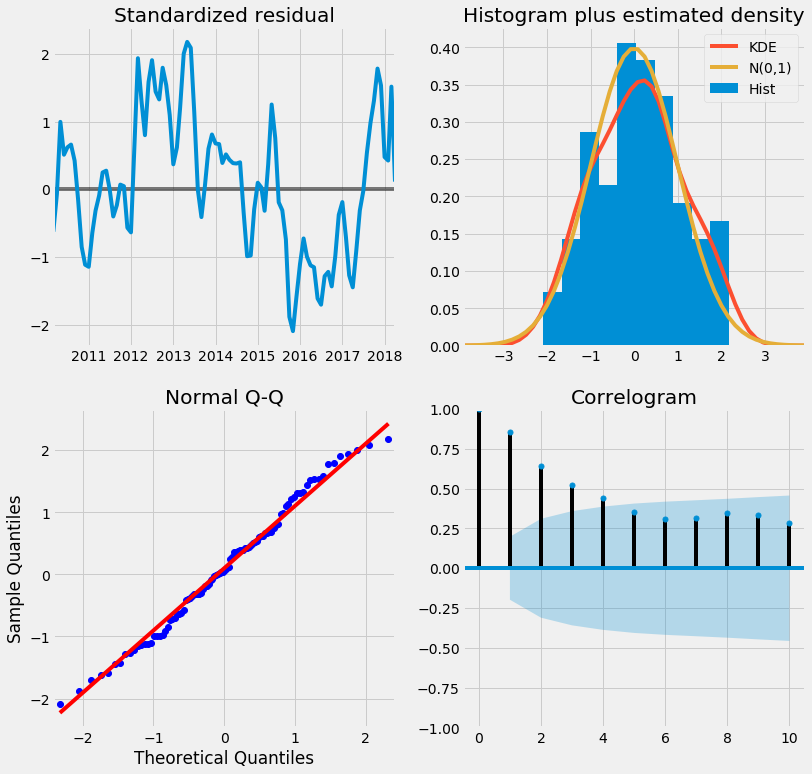

In [65]:
# fit a SARIMA model with the identified paramaters
sj_model3 = SARIMA_modeler(sj_ts, order=(0,1,0), s_order=(1,0,1,12), trend='ct')

model_details(sj_model3)

**Observations:** The residuals appear to be normally distributed but there is some autocorrelation and appears to be some trend in the top left chart

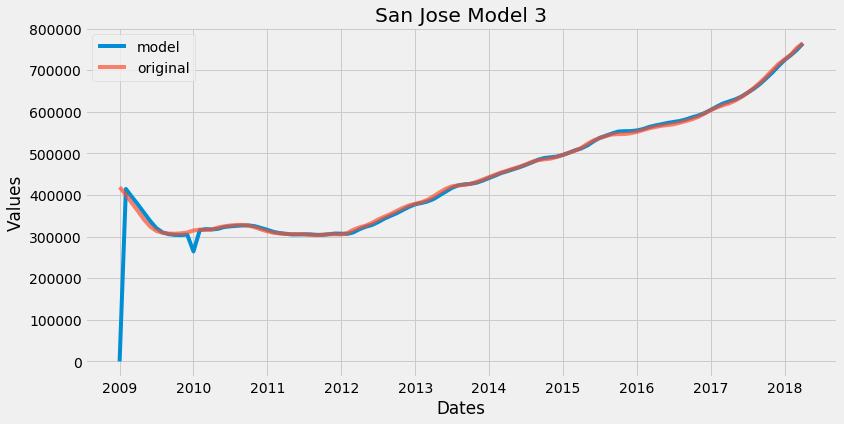

In [66]:
#plot original time series and predictions
plot_model(sj_ts, sj_model3, title='San Jose Model 3')

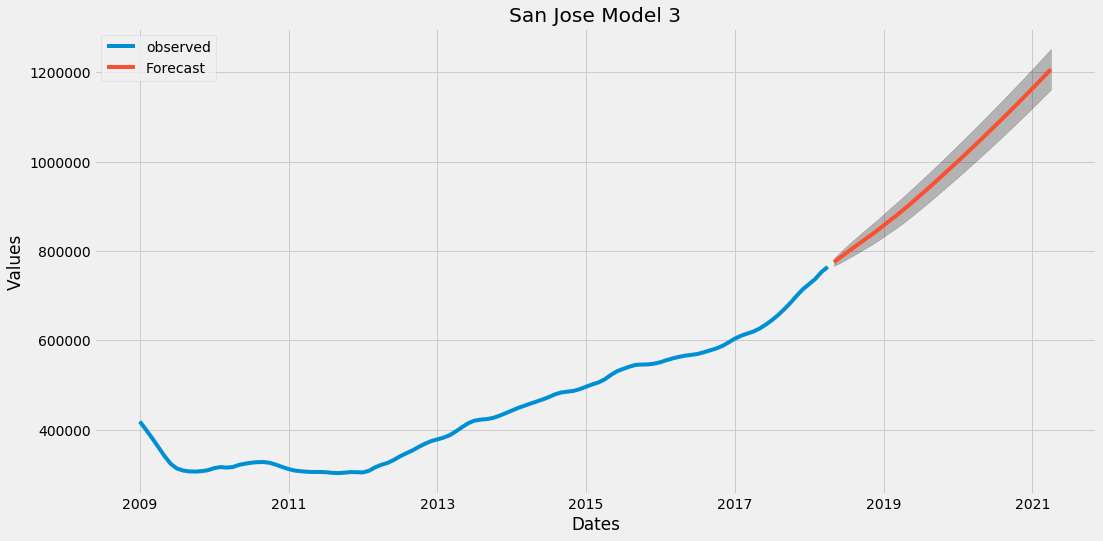

In [67]:
# plot forecast for 36 steps our with confidence interval
plot_forcast_model(sj_ts, sj_model3, alpha=.01, title='San Jose Model 3')

**Observations:** This is looks like a pretty tight prediction, even working with a 99% confidence interval. I am a little concerned with over-fitting which is interesting given that this in the first time we have worked in a train-test split. 

### Calculation ROI and expected growth - San Jose Model 2 & 3 

At this point we may not keep San Jose in our consideration, but we should finish doing our investment analysis and we can return to a final decision later in our work. 

To do this I have made two more functions, **expected_growth** and **ROI_calculator**. These two functions use the forecast model values to get range of potential return on investing a nominal 10mm dollars in this area. 

#### San Jose Model 2 Return

In [68]:
# calculate the expected growth interval for 36 periods forward with a 95% confidence interval
expected_growth(model=sj_model2, name= 'San Jose (Model 2)');

With a 95% confidence interval San Jose (Model 2) is forecasted to grow at the following rates after 36 months: 

	 Upper Rate: 93.3%
	 Mean Rate: 54.7%
	 Lower Rate: 15.7%

With a range of $610946.8 between the higest and lowest projected values.


In [69]:
ROI_calculator(model=sj_model2, ts=sj_ts, name='San Jose (Model 2)' )

An initial investment of $10000000.0 in San Jose (Model 2) would:

	 Allow us to buy approximately 13.0 properties.
	 With a mean projected growth of 54.7% over 36 months we would net a $5438037.28 return
	 or $418310.56 per property.

	 With upper and lower growth rates at 93.3% and 15.7%,
	 we can project a total return between $1564483.97 and $9273672.59


#### San Jose Model 3 Return

In [70]:
# calculate the expected growth interval for 36 periods forward with a 95% confidence interval
expected_growth(model=sj_model3, name= 'San Jose (Model 3)');

With a 95% confidence interval San Jose (Model 3) is forecasted to grow at the following rates after 36 months: 

	 Upper Rate: 58.8%
	 Mean Rate: 55.7%
	 Lower Rate: 52.5%

With a range of $69138.98 between the higest and lowest projected values.


In [71]:
ROI_calculator(model=sj_model3, ts=sj_ts, name='San Jose (Model 3)')

An initial investment of $10000000.0 in San Jose (Model 3) would:

	 Allow us to buy approximately 13.0 properties.
	 With a mean projected growth of 55.7% over 36 months we would net a $5531594.02 return
	 or $425507.2323076923 per property.

	 With upper and lower growth rates at 58.8% and 52.5%,
	 we can project a total return between $5213892.19 and $5844074.46


### San Jose Conclusions:

With both models predicting a mean around 55% growth over 3yrs this is an attractive area. We'll take a look at Weehawken though before making a decision. 

### Weehawken Modeling

As before, we will work through a stationarity check and ACF / PACF analysis for learning purposes, but from here on out we will forgo the transformations and focus mostly on SARIMA models

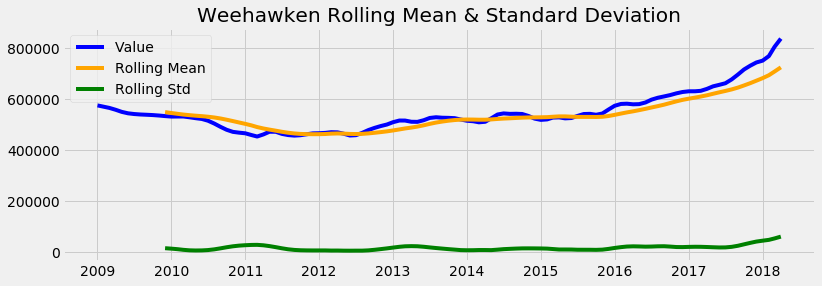

Results of Dickey-Fuller Test:
Test Statistic                   1.659369
p-value                          0.998025
#Lags Used                       8.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


In [72]:
#stationarity check
stationarity_check(wh_ts, title='Weehawken')

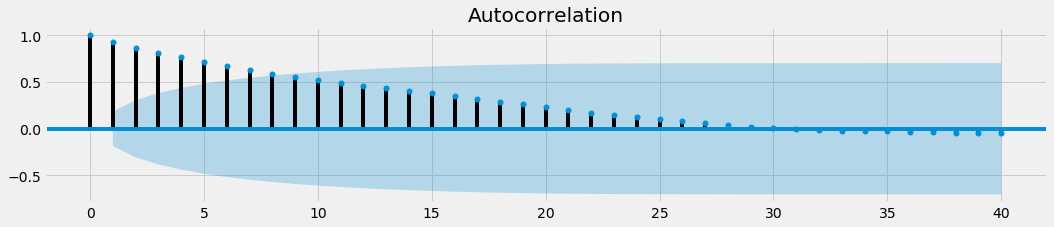

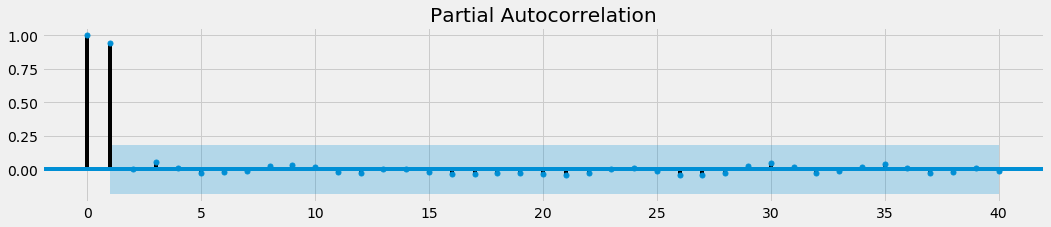

In [73]:
# ACF and PACF

fig, ax = plt.subplots(figsize=(16,3))
plot_acf(wh_ts.dropna(),ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(wh_ts.dropna(),ax=ax, lags=40);

#### Comparing modeling methods

After the results of the last section I am still curious to see what the different methods we've tried will net us, so I will try the two different parameter selections methods one again. 

#### Weehawken Model 1

In [74]:
# find the parameter combination with the lowest AIC, with highest order being 1
SARIMA_iterator(wh_ts)

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1728.16
Name: 59, dtype: object

Model coefficients:  ar.L1       4.874524e-01
ma.L1       1.296808e+00
ma.S.L12    6.582152e-02
sigma2      2.539458e+07
dtype: float64

 Model p_values:  ar.L1       5.727862e-04
ma.L1       1.530457e-70
ma.S.L12    5.588830e-02
sigma2      0.000000e+00
dtype: float64

 Model AIC:  1728.1598579351123


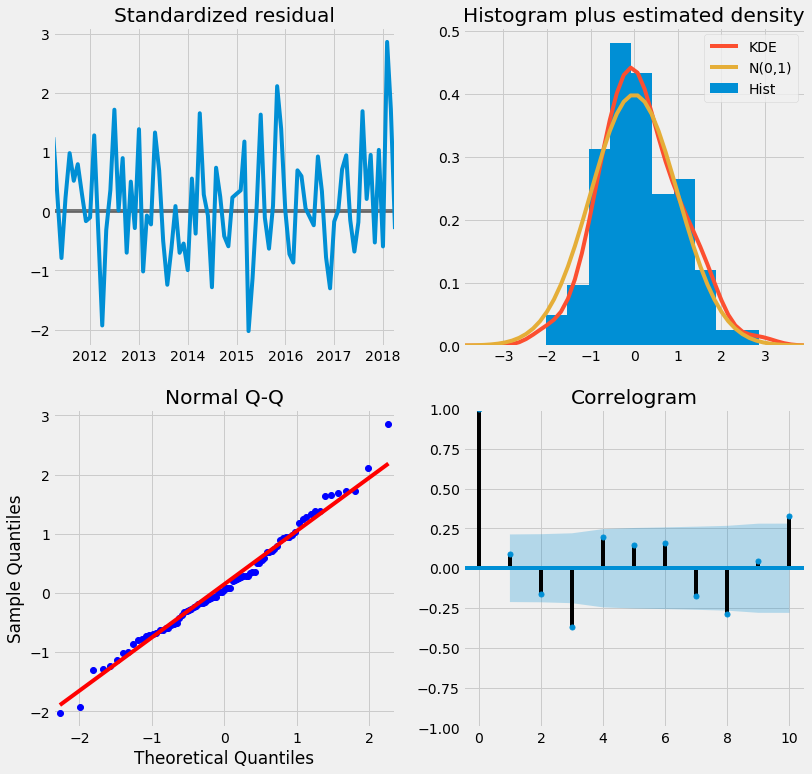

In [75]:
# fit model and display diagnostics
wh_model = SARIMA_modeler(wh_ts, order=(1,1,1), s_order=(0,1,1,12), trend=None)

model_details(wh_model)

**Observations:** this model looks pretty nice. Normal distribution of residuals, low correlation and residuals appear to be white noise

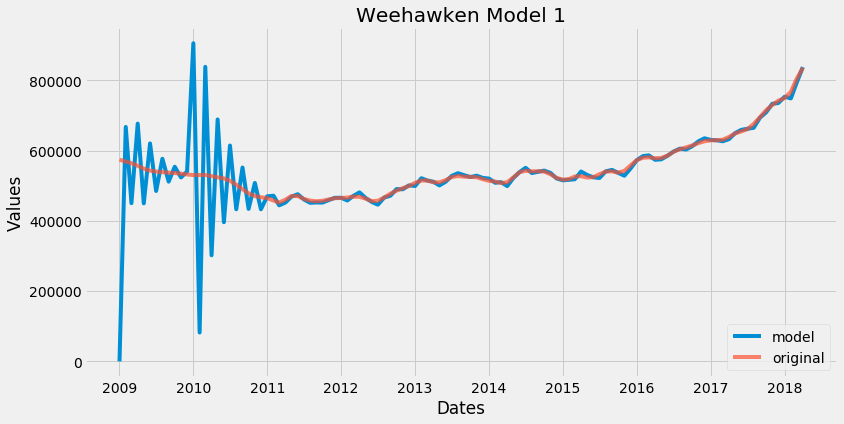

In [76]:
# plot original series and model predictions
plot_model(wh_ts, wh_model,  title='Weehawken Model 1')

The model is noisy in the beginning but is pretty close throughout the rest of the data

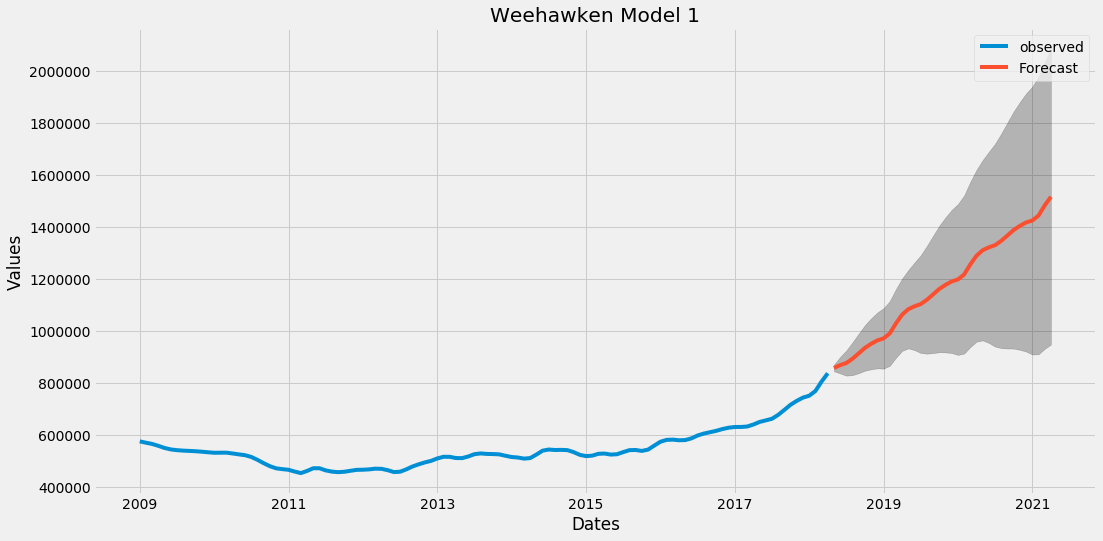

In [77]:
# predict values 36 steps out and plot mean and confidence interval
plot_forcast_model(wh_ts, wh_model, alpha=.05,  title='Weehawken Model 1')

**Observations:** With a 95% confidence interval results are similar to our last model, with the lower end of the range showing smaller growth and the upper range more than doubling. One interesting observation is that the model does seem to suggest some flattening off the current growth spike. 

#### Weehawken Model 2

In [78]:
# Iterate through possible parameters with a 100-12 train-test split and select the lowest MSE
# SARIMA_MSE_Iterator(data=wh_ts, n_test=12, seasonal=[0,12])

Weehawken ntest = 12

[(0, 1, 2), (0, 0, 2, 12), 'ct'] 5694.436743718188

[(0, 1, 1), (0, 0, 2, 0), 't'] 5829.25737219155

[(0, 1, 2), (1, 0, 2, 12), 'ct'] 5927.629494634621

Model coefficients:  intercept   -4.259699e+03
drift        1.294041e+02
ma.L1        1.539077e+00
ma.L2        8.520811e-01
ma.S.L12    -2.239993e-01
ma.S.L24    -5.133988e-01
sigma2       1.285586e+07
dtype: float64

 Model p_values:  intercept    1.064443e-01
drift        6.082943e-03
ma.L1        1.218886e-42
ma.L2        6.668415e-12
ma.S.L12     2.572205e-01
ma.S.L24     1.735276e-02
sigma2       0.000000e+00
dtype: float64

 Model AIC:  1606.0999300227245


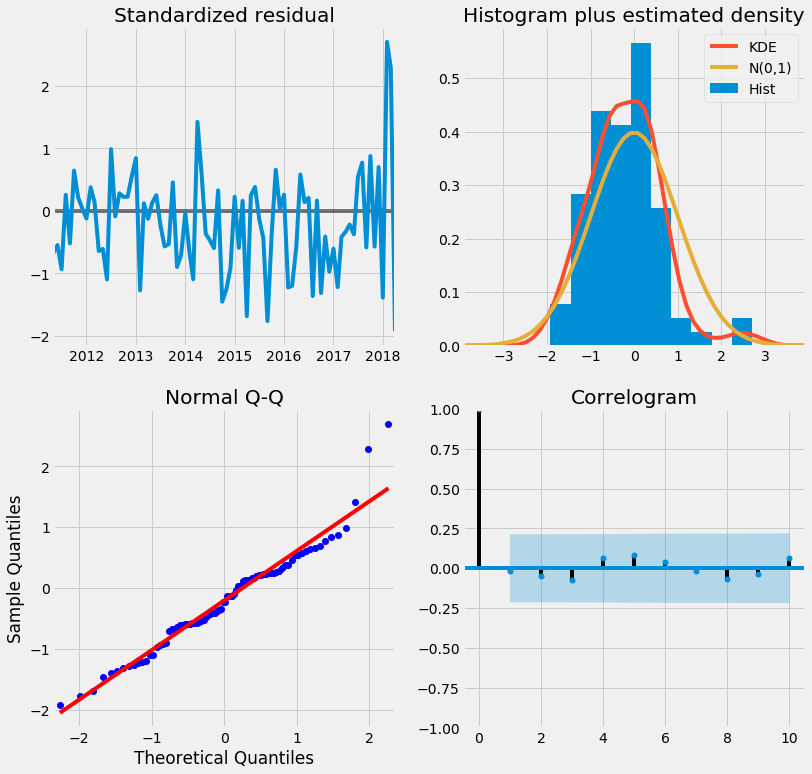

In [79]:
# fit a SARIMA model with the parameters above and display details
order = (0,1,2)
s_order = (0,0,2,12)
trend = 'ct'

wh_model_2 = SARIMA_modeler(wh_ts, order, s_order, trend)

model_details(wh_model_2)

**Observations:** Some parameters are not significant, and there appears to be a some heteroskedasticity. Residuals are not as normally distributed as model 1, but there is also less autocorrelation.

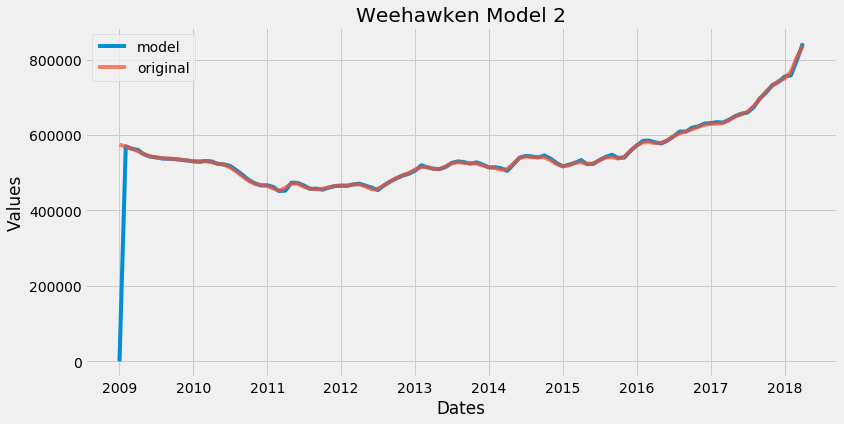

In [80]:
# plot model predictions and original series
plot_model(wh_ts, wh_model_2, title='Weehawken Model 2')

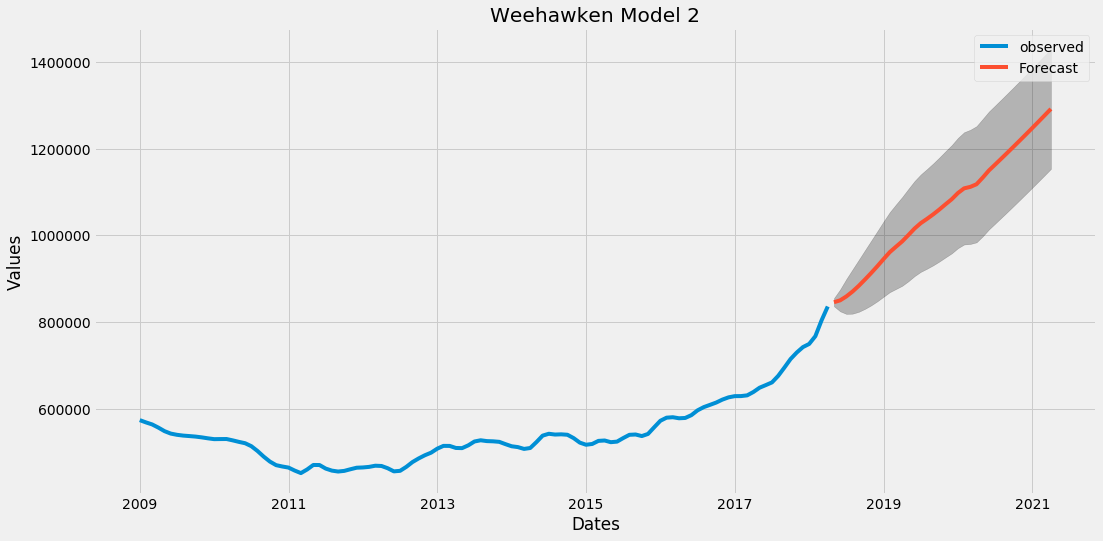

In [81]:
#forecast model out 36 steps and plot mean and confidence interval
plot_forcast_model(wh_ts, wh_model_2, alpha=.01,  title='Weehawken Model 2')

**Observations:** Even with a 99% confidence interval the grid search method again produces a much tighter prediction. 

I'm still concerned about over-fitting at this point so lets try this method again but this time with a large train-test split 

#### Weehawken Model 3

In [82]:
# iterate through SARIMA parameters and set aside the last 24 values as a training set
# SARIMA_MSE_Iterator(data=wh_ts, n_test=24, seasonal=(0,12))

Weehawken ntest = 24

[(2, 1, 0), (1, 0, 0, 0), 'ct'] 4430.741800455374

[(1, 1, 0), (2, 0, 0, 0), 'ct'] 4485.296620763186

[(2, 1, 0), (2, 0, 1, 0), 'ct'] 4524.024186982534

**Observations:** Interestingly enough the parameters are pretty different with the only thing being different being the larger set of test data, and the MSE went down by nearly 1000

Model coefficients:  intercept   -2.989732e+03
drift        6.386019e+01
ar.L1        6.248078e-01
ar.L2       -7.262599e-01
ar.S.L1      7.142762e-01
sigma2       1.124928e+07
dtype: float64

 Model p_values:  intercept    4.284949e-03
drift        3.123868e-04
ar.L1        4.015415e-11
ar.L2        3.238136e-17
ar.S.L1      7.986385e-18
sigma2       0.000000e+00
dtype: float64

 Model AIC:  2074.228532589069


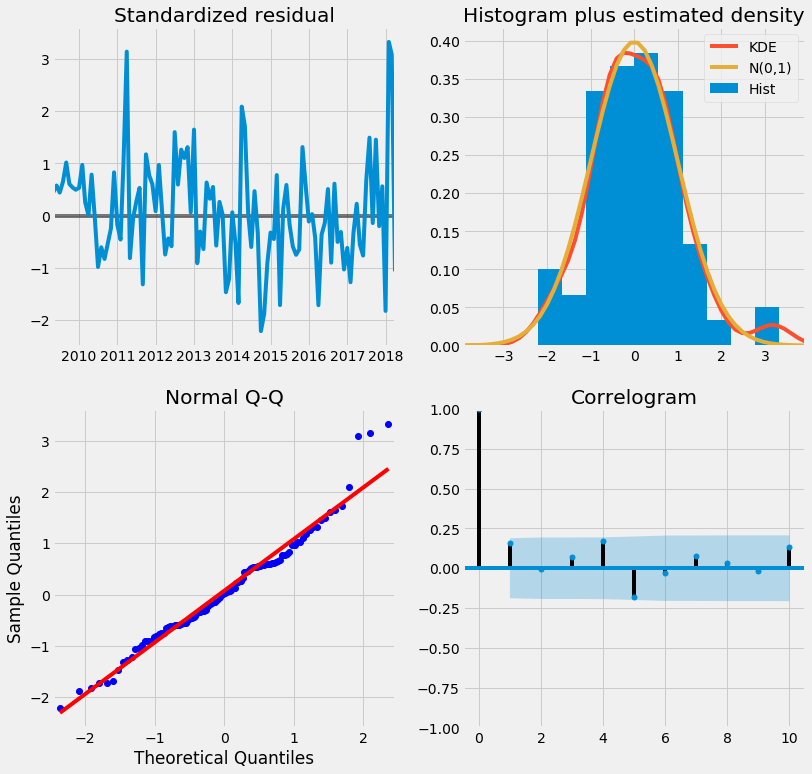

In [83]:
# fit a SARIMA model with the parameters above and display details
order = (2,1,0)
s_order = (1,0,0,0)
trend = 'ct'

wh_model_3 = SARIMA_modeler(wh_ts, order, s_order, trend)

model_details(wh_model_3)

**Observations:** This model appears to fit the best so far, with significant model parameters and normality assumptions met.

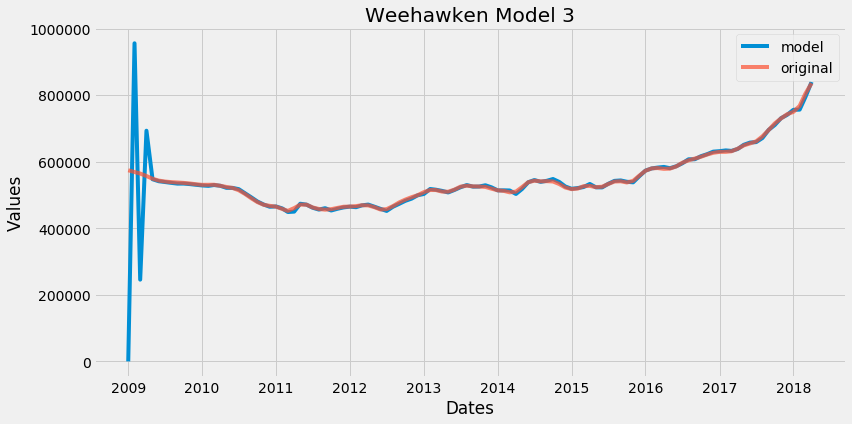

In [84]:
#plot original series and model predictions
plot_model(wh_ts, wh_model_3,  title='Weehawken Model 3')

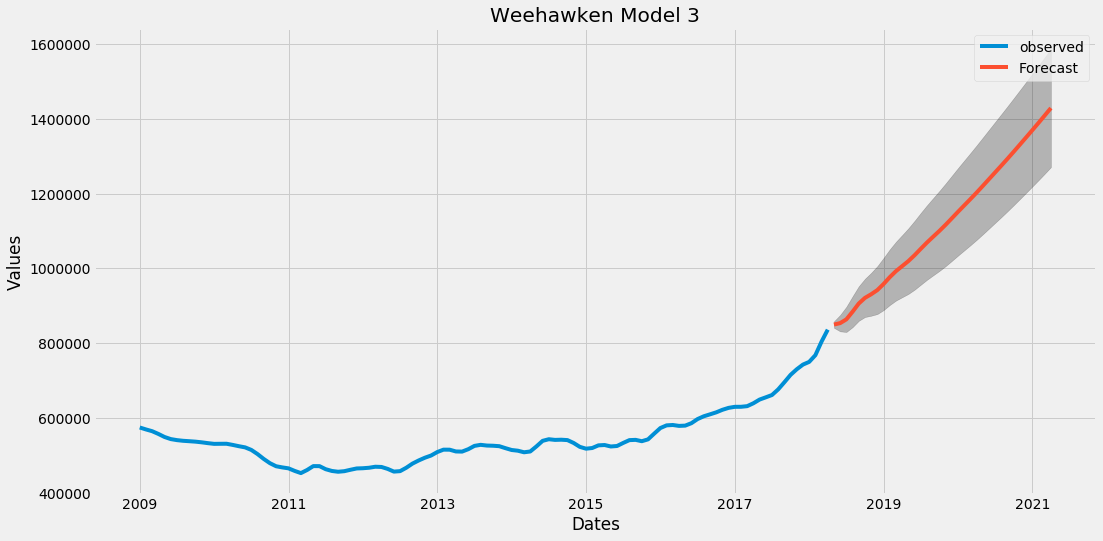

In [85]:
# plot forecast our 36 steps with a 99% confidence interval
plot_forcast_model(wh_ts, wh_model_3, title='Weehawken Model 3')

**Observations:** This model appears to be slightly tighter than the last one and with a larger test group and more robust diagnostics likely to be more accurate as well. 

Let's see compare expected growth and ROI between the two. 

### Calculation ROI and expected growth - Weehawken Model 2 & 3 

#### Weehawken Model 2 Return 

In [86]:
# calculate the expected growth interval for 36 periods forward with a 95% confidence interval
expected_growth(wh_model_2, name='Weehawken (Model 2)');

With a 95% confidence interval Weehawken (Model 2) is forecasted to grow at the following rates after 36 months: 

	 Upper Rate: 63.7%
	 Mean Rate: 52.6%
	 Lower Rate: 41.4%

With a range of $210333.42 between the higest and lowest projected values.


In [87]:
ROI_calculator(wh_model_2, ts=wh_ts, name='Weehawken (Model 2)')

An initial investment of $10000000.0 in Weehawken (Model 2) would:

	 Allow us to buy approximately 11.0 properties.
	 With a mean projected growth of 52.6% over 36 months we would net a $4840688.86 return
	 or $440062.62363636366 per property.

	 With upper and lower growth rates at 63.7% and 41.4%,
	 we can project a total return between $3805673.77 and $5858603.74


#### Weehawken Model 3 Return

In [88]:
# calculate the expected growth interval for 36 periods forward with a 95% confidence interval
expected_growth(wh_model_3, name='Weehawken (Model 3)');

With a 95% confidence interval Weehawken (Model 3) is forecasted to grow at the following rates after 36 months: 

	 Upper Rate: 80.9%
	 Mean Rate: 68.2%
	 Lower Rate: 55.2%

With a range of $240637.73 between the higest and lowest projected values.


In [89]:
ROI_calculator(wh_model_3, ts=wh_ts, name='Weehawken (Model 3)')

An initial investment of $10000000.0 in Weehawken (Model 3) would:

	 Allow us to buy approximately 11.0 properties.
	 With a mean projected growth of 68.2% over 36 months we would net a $6269953.68 return
	 or $569995.7890909091 per property.

	 With upper and lower growth rates at 80.9% and 55.2%,
	 we can project a total return between $5078095.56 and $7443512.12


### Weehawken Conclusions

Despite the cleaner looking plot, Model 3 has a slightly wider confidence interval and predicts higher values potential growth. Model 3 had a lower MSE, but a much higher AIC. The range of the interval is roughly consitent. Even though I would like to believe the higher growth predictions, it seems prudent to stick with model 2 in this case. 

## High Value Area Conclusions

In this segment we are choosing roughly between:
- A 5.5mm dollar return in San Jose, with the opportunity to purchase 13 properties
- A 4.8mm dollar return in Weehawken, with the opportunity to purchase 11 properties

Predictions for **San Jose 95116** seem to be more consistent as well, and therefore we will choose it as our High Value investment area. 

# Medium Value Models

We'll now repeat the process for our Medium Value areas with the goal of selecting two areas to invest in. As mentioned previously from this point on in the project will move straight into modeling, since we will not be doing any direct transformations for stationarity and are iterating to choose our model parameters. 

In [90]:
# isolate data for time series modeling in our three target areas: Union City, Jersey City, Oakland
uc_ts = uc_ts['value']
jc_ts = jc_ts['value']
ok_ts = ok_ts['value']

### Union City Modeling

In [91]:
# iterate through model parameters with a max order of 1 and choose lowest AIC
SARIMA_iterator(uc_ts)

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           1564.25
Name: 63, dtype: object

Model coefficients:  ar.L1       6.698164e-01
ma.L1       6.636230e-01
ar.S.L12    1.653657e-01
ma.S.L12   -2.645551e-01
sigma2      4.722395e+06
dtype: float64

 Model p_values:  ar.L1       5.306824e-16
ma.L1       7.100206e-13
ar.S.L12    2.286976e-02
ma.S.L12    1.123220e-02
sigma2      0.000000e+00
dtype: float64

 Model AIC:  1564.2527185874194


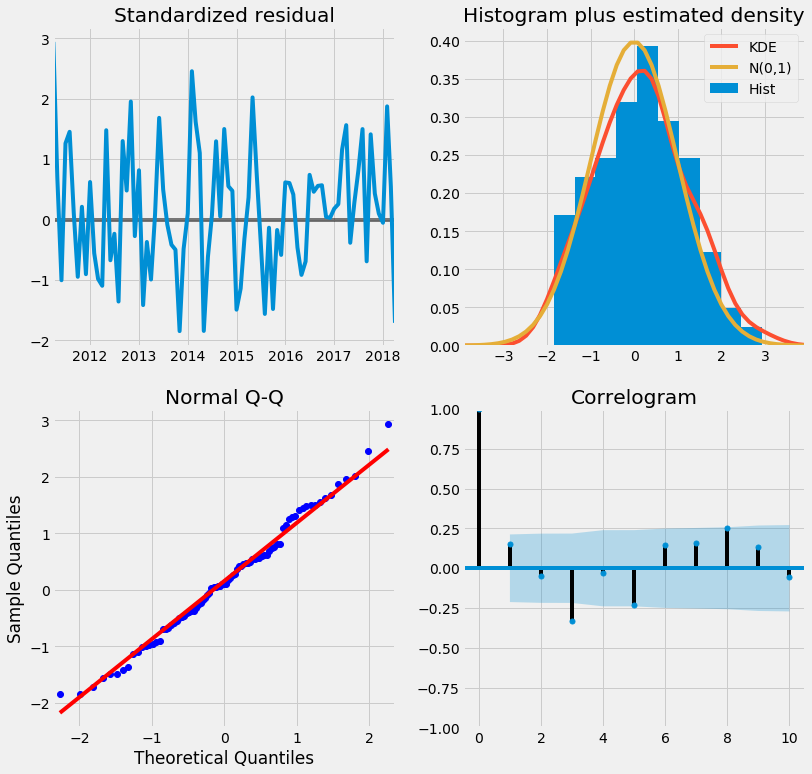

In [92]:
# fit model and display diagnostics
uc_model_1 = SARIMA_modeler(uc_ts, order=(1,1,1), s_order=(1,1,1,12), trend=None)

model_details(uc_model_1)

**Observations:** Features appear significant and normality assumptions are met

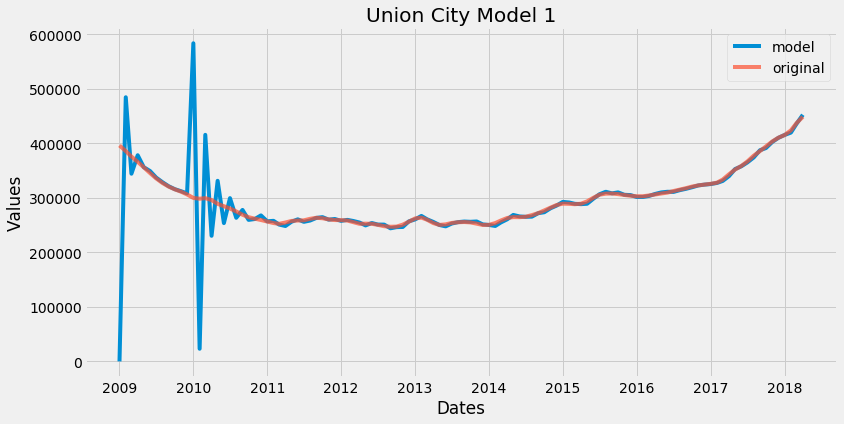

In [93]:
# plot original data and model predictions
plot_model(uc_ts, uc_model_1, title='Union City Model 1')

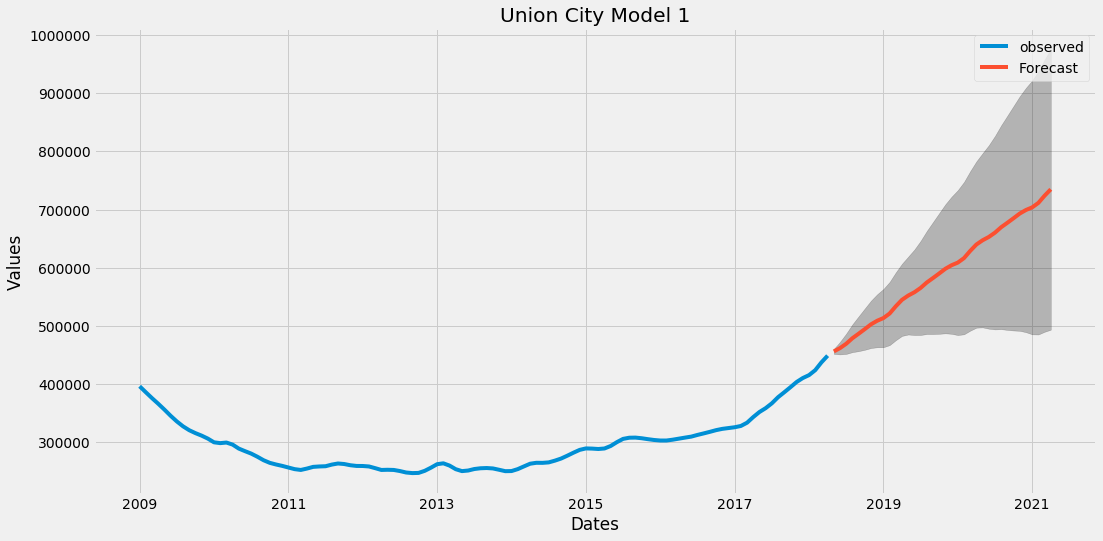

In [94]:
# forecast values 36 steps our with a 95% confidence interval
plot_forcast_model(uc_ts, uc_model_1, alpha=.05, title='Union City Model 1')

#### Union City Model 2

In [95]:
# Iterate through possible parameters with a 100-12 train-test split and select the lowest MSE
# SARIMA_MSE_Iterator(data=uc_ts, n_test=12, seasonal=[0,12])

Union City

[(0, 1, 1), (0, 0, 2, 0), 'ct'] 1584.4407099416721

[(0, 1, 2), (1, 0, 2, 0), 'ct'] 1710.7418798735648

[(0, 1, 0), (2, 0, 1, 0), 'ct'] 1787.2712140628823

Model coefficients:  intercept   -4.815991e+03
drift        1.046504e+02
ma.L1        2.432338e-01
ma.S.L1      1.415105e+00
ma.S.L2      7.452090e-01
sigma2       4.878745e+06
dtype: float64

 Model p_values:  intercept    0.070254
drift        0.007226
ma.L1        0.473882
ma.S.L1      0.000006
ma.S.L2      0.003611
sigma2       0.000042
dtype: float64

 Model AIC:  1895.1466669746148


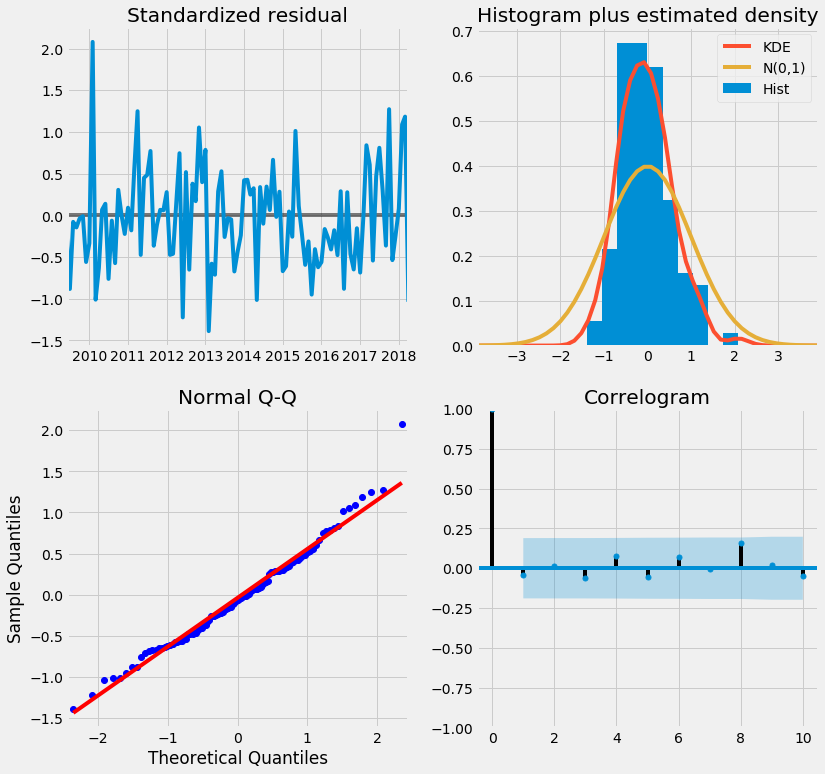

In [96]:
order = (0,1,1)
s_order = (0,0,2,0)
trend = 'ct'

uc_model_2 = SARIMA_modeler(uc_ts, order, s_order, trend)

model_details(uc_model_2)

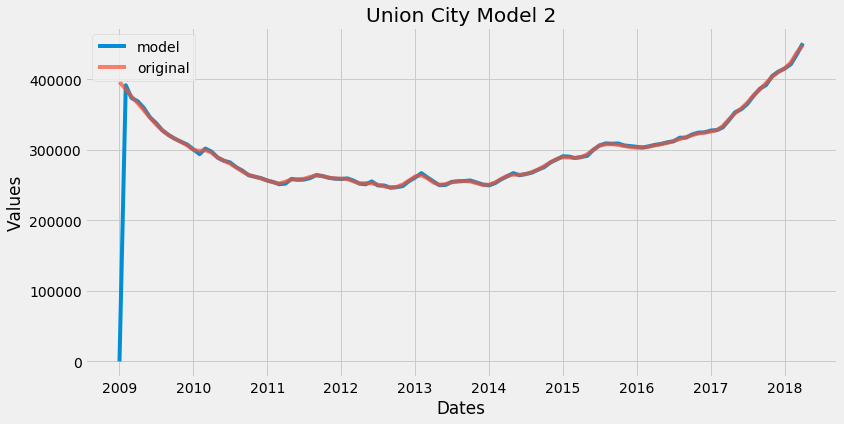

In [97]:
# plot original series and predicted values
plot_model(uc_ts, uc_model_2, title='Union City Model 2')

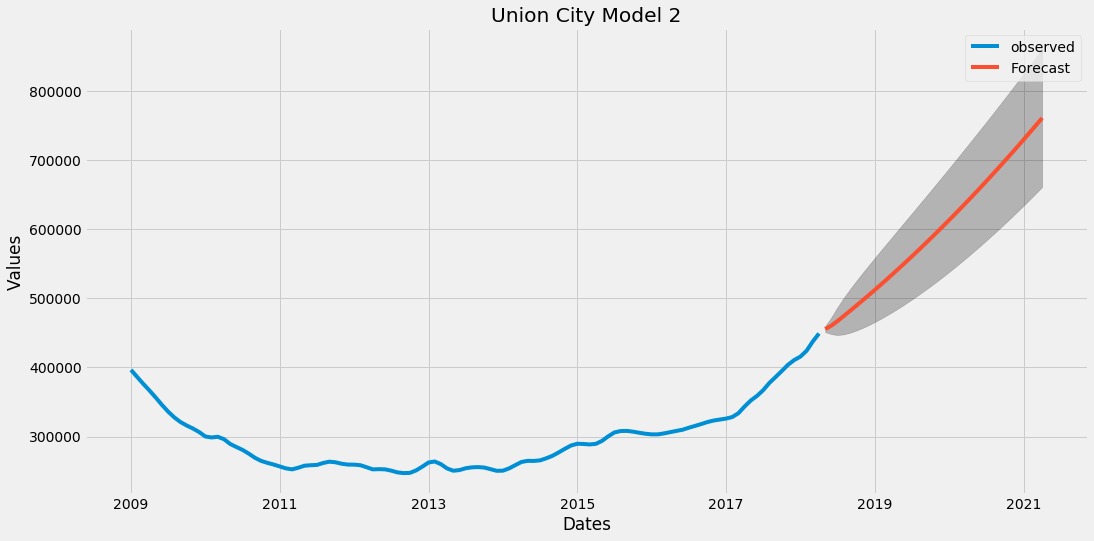

In [98]:
# plot forecast values 36 steps out with a 95% confidence interval
plot_forcast_model(uc_ts, uc_model_2, title='Union City Model 2', alpha=.05)

### Calculation ROI and expected growth - Union City Model 1 & 2 

#### Union City Model 1 Return

In [99]:
# calculate the expected growth interval for 36 periods forward with a 95% confidence interval
expected_growth(uc_model_1, name='Union City (Model 1)');

With a 95% confidence interval Union City (Model 1) is forecasted to grow at the following rates after 36 months: 

	 Upper Rate: 112.0%
	 Mean Rate: 61.1%
	 Lower Rate: 9.2%

With a range of $482546.88 between the higest and lowest projected values.


In [100]:
ROI_calculator(uc_model_1, uc_ts, name='Union City (Model 1)')

An initial investment of $10000000.0 in Union City (Model 1) would:

	 Allow us to buy approximately 22.0 properties.
	 With a mean projected growth of 61.1% over 36 months we would net a $6030885.99 return
	 or $274131.1813636364 per property.

	 With upper and lower growth rates at 112.0% and 9.2%,
	 we can project a total return between $908840.83 and $11058180.42


#### Union City Model 2 Return

In [101]:
# calculate the expected growth interval for 36 periods forward with a 95% confidence interval
expected_growth(uc_model_2, name='Union City (Model 2)');

With a 95% confidence interval Union City (Model 2) is forecasted to grow at the following rates after 36 months: 

	 Upper Rate: 87.2%
	 Mean Rate: 67.0%
	 Lower Rate: 46.5%

With a range of $199617.62 between the higest and lowest projected values.


In [102]:
ROI_calculator(model=uc_model_2, ts=uc_ts, name= 'Union City (Model 2)')

An initial investment of $10000000.0 in Union City (Model 2) would:

	 Allow us to buy approximately 22.0 properties.
	 With a mean projected growth of 67.0% over 36 months we would net a $6619359.12 return
	 or $300879.96 per property.

	 With upper and lower growth rates at 87.2% and 46.5%,
	 we can project a total return between $4591957.0 and $8608569.22


### Union City Conclusions

The mean growth between the two models in relatively close (~6%), but the confidence interval of model 2 is much tighter, so we will consider that one going forward. It is also notable that even with the tighter interval, there is still 40 points between the upper and lower ends of the model 2 confidence interval. 

### Jersey City Modeling 

At this point it seems clear that our grid search method is the most accurate one, so we will use it going forward, putting aside potential concerns for over-fitting at this time. 

In [103]:
# Iterate through possible parameters with a 100-12 train-test split and select the lowest MSE
# SARIMA_MSE_Iterator(data=jc_ts, n_test=12, seasonal=[0,12])

Jersey City

[(0, 1, 1), (0, 0, 2, 12), 't'] 2811.571560609667

[(0, 1, 2), (1, 1, 1, 12), 'c'] 2892.186193035914

[(0, 1, 2), (1, 0, 1, 12), 'ct'] 2968.477348900775

Model coefficients:  drift       6.228809e+01
ma.L1       8.877197e-01
ma.S.L12    2.015986e-01
ma.S.L24    1.822489e-01
sigma2      4.026677e+06
dtype: float64

 Model p_values:  drift       4.580623e-11
ma.L1       1.471986e-24
ma.S.L12    2.031532e-01
ma.S.L24    2.496055e-01
sigma2      7.055914e-17
dtype: float64

 Model AIC:  1544.465376131336


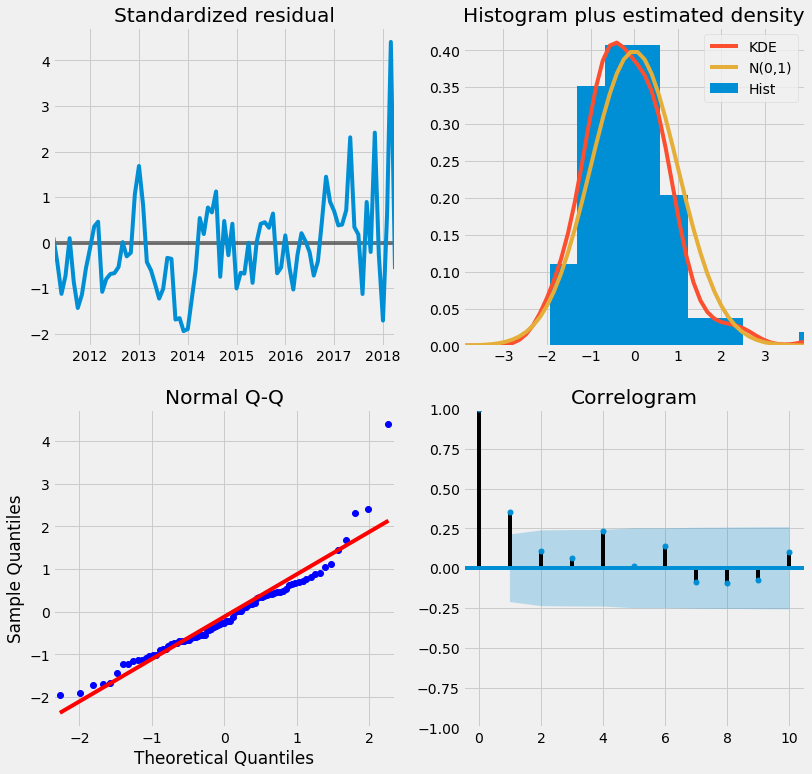

In [104]:
# fit model based on parameters above and display diagnostics
order = (0,1,1)
s_order = (0,0,2,12)
trend = 't'

jc_model = SARIMA_modeler(jc_ts, order, s_order, trend)

model_details(jc_model)

**Observations:** AIC is relatively low compared to other models but the features are not all significant. Normality assumptions appear to hold, but with some heteroskedasticity

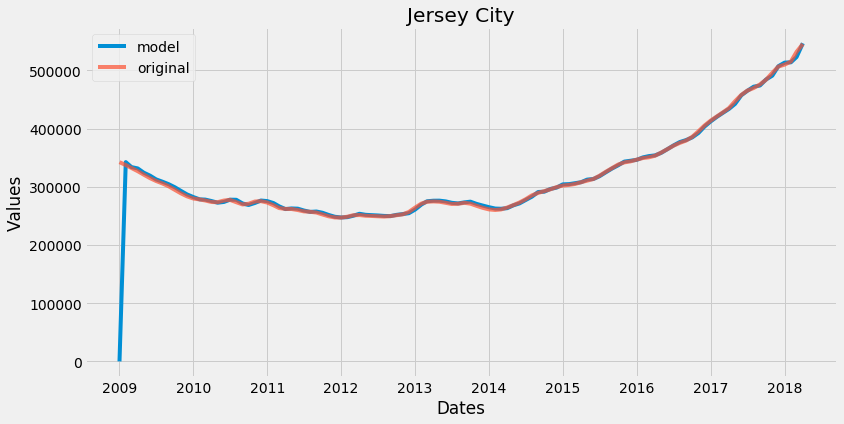

In [105]:
# plot original series and predicted values
plot_model(jc_ts, jc_model, title='Jersey City')

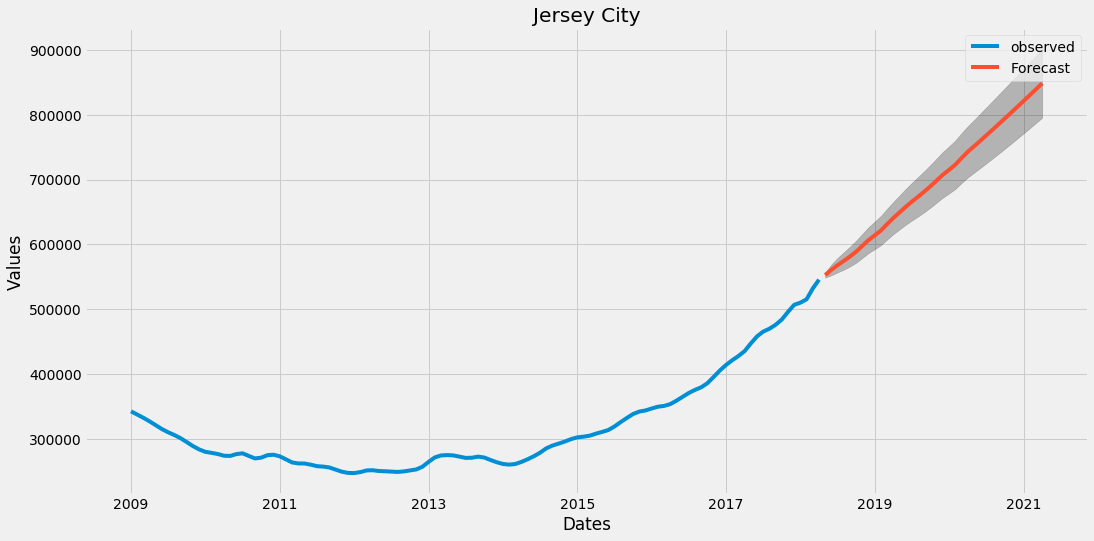

In [106]:
# plot forecast values 36 steps out with a 95% confidence interval
plot_forcast_model(jc_ts, jc_model, title='Jersey City', alpha=.05)

### Calculate ROI and expected growth - Jersey City 

In [107]:
# calculate the expected growth interval for 36 periods forward with a 95% confidence interval
expected_growth(jc_model, name='Jersey City');

With a 95% confidence interval Jersey City is forecasted to grow at the following rates after 36 months: 

	 Upper Rate: 62.0%
	 Mean Rate: 53.5%
	 Lower Rate: 44.9%

With a range of $106184.85 between the higest and lowest projected values.


In [108]:
ROI_calculator(model=jc_model, ts= jc_ts, name='Jersey City')

An initial investment of $10000000.0 in Jersey City would:

	 Allow us to buy approximately 18.0 properties.
	 With a mean projected growth of 53.5% over 36 months we would net a $5254041.19 return
	 or $291891.17722222226 per property.

	 With upper and lower growth rates at 62.0% and 44.9%,
	 we can project a total return between $4411976.04 and $6084205.2


### Jersey City Conclusions

Jersey City shows promising growth at 53.5% and a relatively tight confidence interval, with less than 20% between the top and bottom predictions. 

## Oakland Modeling

In [109]:
# Iterate through possible parameters with a 100-12 train-test split and select the lowest MSE
# SARIMA_MSE_Iterator(data=ok_ts, n_test=12, seasonal=[0,12])

Oakland

[(2, 0, 0), (2, 1, 1, 12), 'c'] 1166.4154685349204

[(0, 1, 1), (0, 0, 2, 0), 't'] 1198.627307613101

[(0, 1, 1), (2, 1, 1, 12), 'ct'] 1202.6721111403738

**Observations:** These are low MSEs relative to other Medium value area results, this may be the best fit model of the segment

Model coefficients:  intercept    6.492825e+02
ar.L1        1.819494e+00
ar.L2       -8.271442e-01
ar.S.L12    -3.904690e-01
ar.S.L24     1.934430e-01
ma.S.L12    -3.171731e-01
sigma2       6.210919e+06
dtype: float64

 Model p_values:  intercept    3.556790e-01
ar.L1        7.360802e-49
ar.L2        5.327764e-12
ar.S.L12     5.262183e-01
ar.S.L24     5.815308e-01
ma.S.L12     5.612146e-01
sigma2       0.000000e+00
dtype: float64

 Model AIC:  1345.742954328442


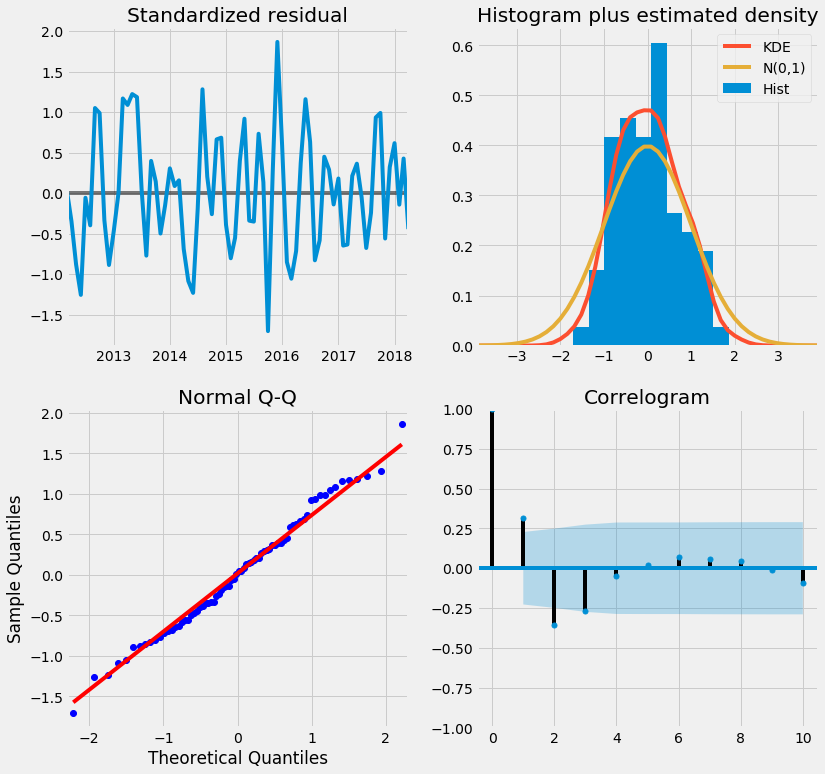

In [110]:
# fit model based on parameters above and display diagnostics
order = (2,0,0)
s_order = (2,1,1,12)
trend = 'c'

ok_model = SARIMA_modeler(ok_ts, order, s_order, trend)

model_details(ok_model)

**Observations:** Our model p-values are relatively high, but AIC is lower than other models and normality assumptions appear ok

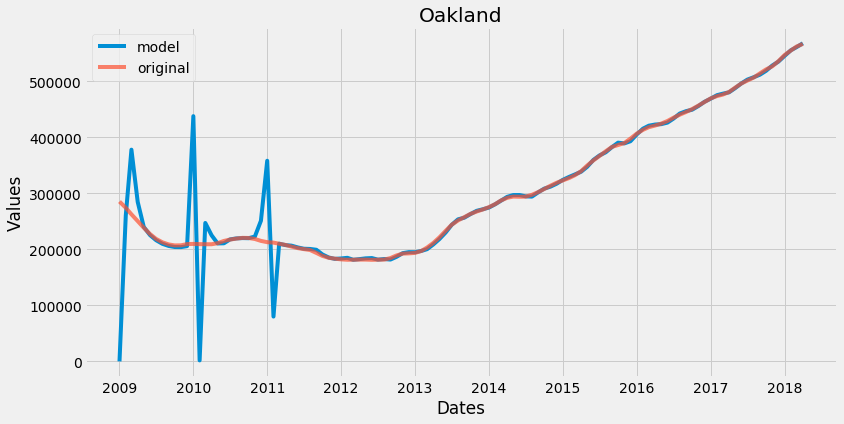

In [111]:
# plot original series and predicted values
plot_model(ok_ts, ok_model, title='Oakland')

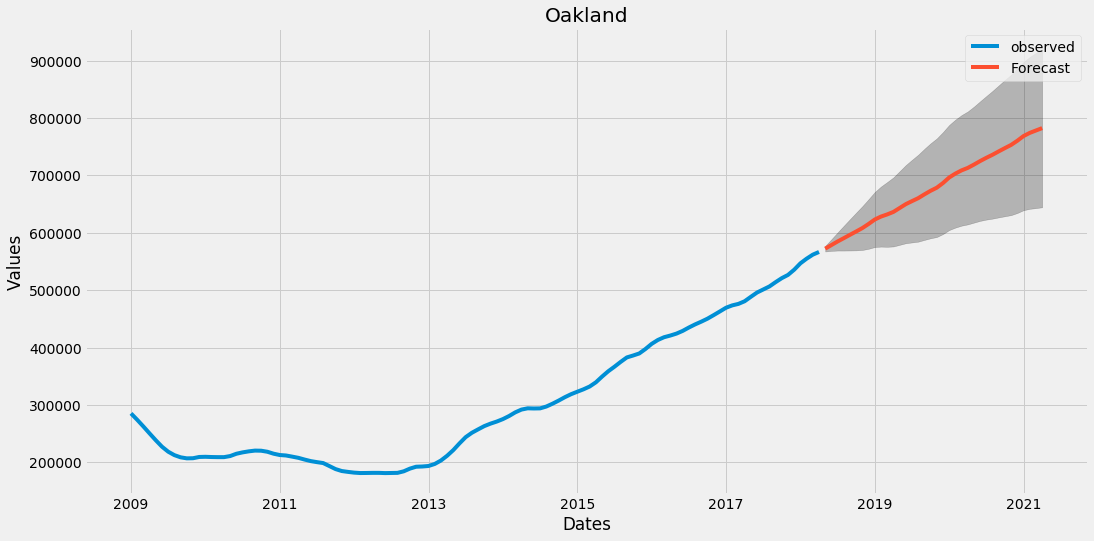

In [112]:
# plot forecast values 36 steps out with a 95% confidence interval
plot_forcast_model(ok_ts, ok_model, title='Oakland', alpha=.05)

### Calculate ROI and expected growth - Oakland 

In [113]:
# calculate the expected growth interval for 36 periods forward with a 95% confidence interval
expected_growth(ok_model, name='Oakland');

With a 95% confidence interval Oakland is forecasted to grow at the following rates after 36 months: 

	 Upper Rate: 59.5%
	 Mean Rate: 36.7%
	 Lower Rate: 13.6%

With a range of $275946.77 between the higest and lowest projected values.


In [114]:
ROI_calculator(model=ok_model, ts=ok_ts, name='Oakland')

An initial investment of $10000000.0 in Oakland would:

	 Allow us to buy approximately 17.0 properties.
	 With a mean projected growth of 36.7% over 36 months we would net a $3536619.82 return
	 or $208036.46 per property.

	 With upper and lower growth rates at 59.5% and 13.6%,
	 we can project a total return between $1307906.22 and $5727619.65


### Oakland Conclusions



Oakland has a more modest expected growth rate at 36.7% and a fairly wide confidence interval. The growth does look steady, but there may be more doubt here than we anticipated 

## Medium Value Area Conclusions

In this segment we are choosing roughly between:
- A 6.6mm dollar, 67% return in **Union City**, with the opportunity to purchase 22 properties
    - a roughly 41% confidence interval, with upper and lower growth rates at 87.2% and 46.5%


- A 5.3mm dollar, 53.5% return in **Jersey City**, with the opportunity to purchase 18 properties
    - a roughly 17% confidence interval, with upper and lower growth rates at 62.0% and 44.9%
    

- A 3.5mm dollar, 36.7% return in **Oakland**, with the opportunity to purchase 17 properties
    - a roughly 46% confidence interval, with upper and lower growth rates at 59.5% and 13.6%
  
Due the larger return, but perhaps more importantly, the better confidence intervals, we will choose **Union City 7087** and **Jersey City 7306**.

The lower end of the confidence interval for these areas also both exceed our benchmark 3 year growth rate of 20%. 

# Lower Value Models

We now have a pretty exstablished process for working through our models, which we will repeat again for our lower value areas. 

In [115]:
# isolate data for time series modeling in our three target areas: Vallejo, Aurora, Lake Worth
va_ts = va_ts['value']
au_ts = au_ts['value']
lw_ts =lw_ts['value']

### Vallejo Modeling

In [116]:
# Iterate through possible parameters with a 100-12 train-test split and select the lowest MSE
# SARIMA_MSE_Iterator(data=va_ts, n_test=12, seasonal=[0,12])

Vallejo

[(2, 1, 0), (0, 0, 2, 0), 't'] 585.1198777725305

[(0, 1, 2), (0, 0, 2, 12), 't'] 612.9608755369834

[(1, 0, 2), (0, 0, 2, 0), 't'] 620.5065588874785

Model coefficients:  drift          12.349236
ar.L1           0.736693
ar.L2          -0.022415
ma.S.L1         0.701788
ma.S.L2         0.132707
sigma2     778758.133775
dtype: float64

 Model p_values:  drift      2.987714e-03
ar.L1      2.535481e-05
ar.L2      8.814127e-01
ma.S.L1    1.700347e-04
ma.S.L2    2.585309e-02
sigma2     5.842088e-10
dtype: float64

 Model AIC:  1768.7964101093446


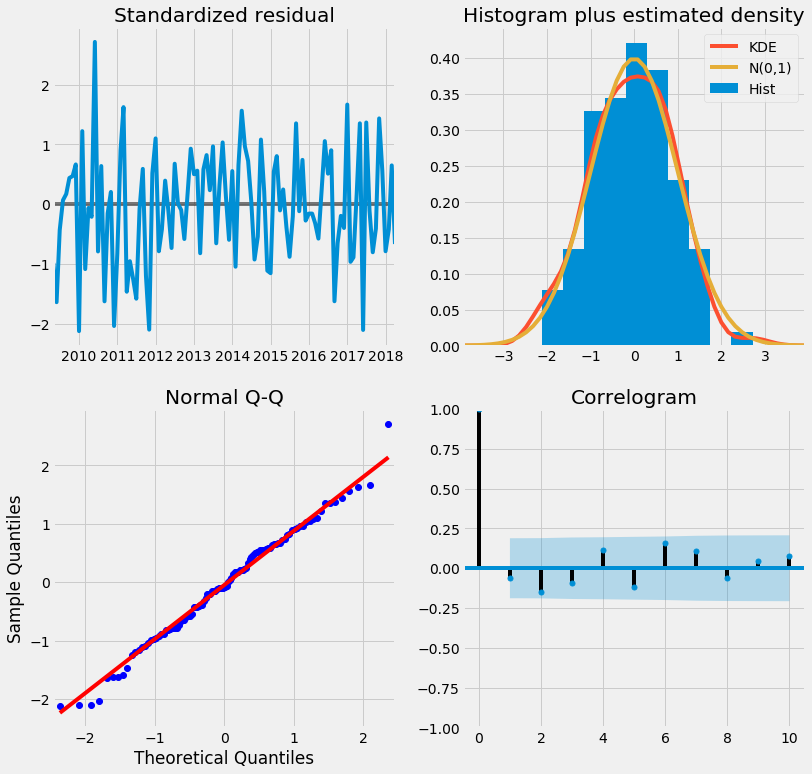

In [117]:
# fit model based on parameters above and display diagnostics
order = (2,1,0)
s_order = (0,0,2,0)
trend = 't'

va_model = SARIMA_modeler(va_ts, order, s_order, trend)

model_details(va_model)

**Observations:** Normality assumptions look good. MSE is much lower that previous for this group but we are working with smaller values now. AIC is slighly higher and not all features are significant. 

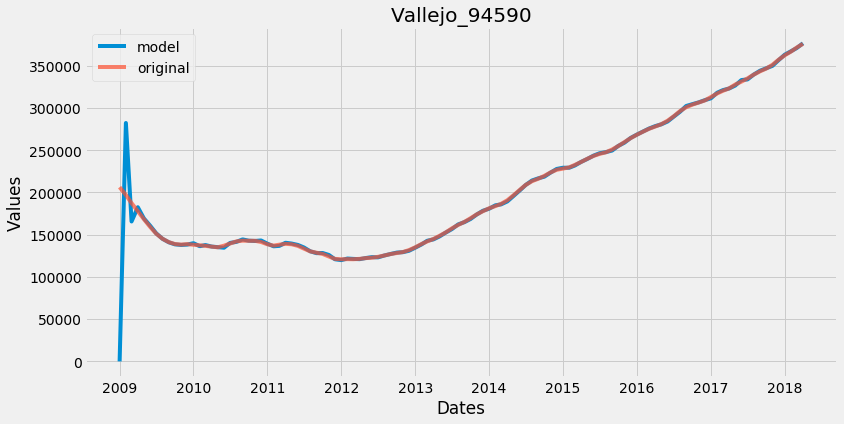

In [118]:
# plot original series and predicted values
plot_model(va_ts, va_model, title='Vallejo_94590')

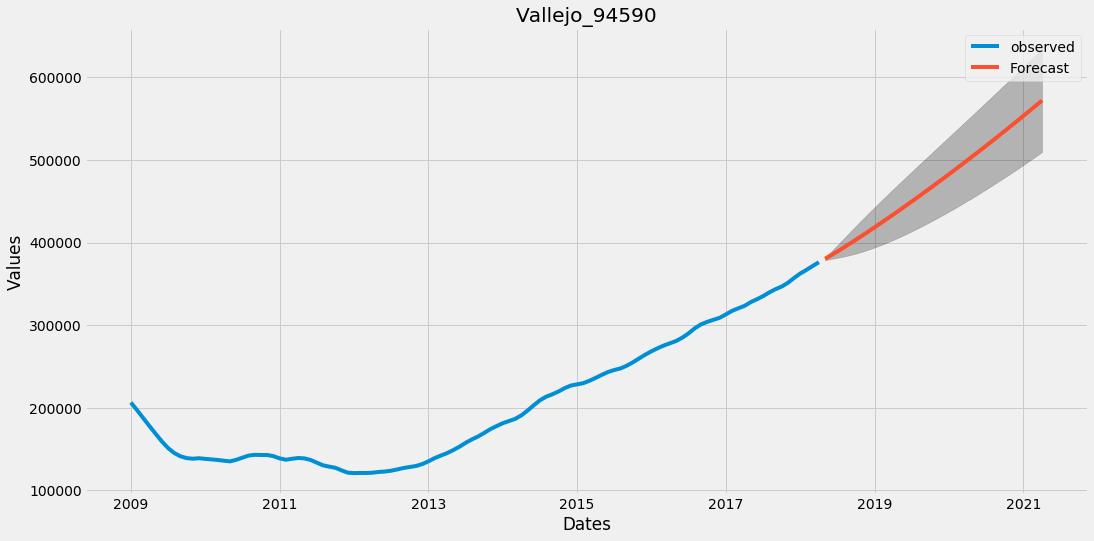

In [119]:
# plot forecast values 36 steps out with a 95% confidence interval
plot_forcast_model(va_ts, va_model, title='Vallejo_94590', alpha=.05)

### Calculate ROI and expected growth - Vallejo 

In [120]:
# calculate the expected growth interval for 36 periods forward with a 95% confidence interval
expected_growth(va_model, name= 'Vallejo');

With a 95% confidence interval Vallejo is forecasted to grow at the following rates after 36 months: 

	 Upper Rate: 66.0%
	 Mean Rate: 50.4%
	 Lower Rate: 34.6%

With a range of $124815.35 between the higest and lowest projected values.


In [121]:
ROI_calculator(model= va_model, ts= va_ts, name= 'Vallejo')

An initial investment of $10000000.0 in Vallejo would:

	 Allow us to buy approximately 26.0 properties.
	 With a mean projected growth of 50.4% over 36 months we would net a $4924220.25 return
	 or $189393.08653846153 per property.

	 With upper and lower growth rates at 66.0% and 34.6%,
	 we can project a total return between $3379613.89 and $6454842.48


### Vallejo Conclusions

There is a relatively good confidence interval of roughly 30% and good mean expected return at 50%

### Aurora Modeling

In [122]:
# Iterate through possible parameters with a 100-12 train-test split and select the lowest MSE
# SARIMA_MSE_Iterator(data=au_ts, n_test=12, seasonal=[0,12])

Aurora

[(2, 0, 1), (1, 0, 1, 12), 'n'] 448.6105986599073

[(2, 0, 2), (1, 0, 1, 12), 't'] 480.13075893777125

[(1, 0, 0), (1, 0, 2, 0), 'n'] 533.2971667855044

Model coefficients:  ar.L1            1.797545
ar.L2           -0.795181
ma.L1           -0.066025
ar.S.L12        -0.117061
ma.S.L12         1.332388
sigma2      231018.538964
dtype: float64

 Model p_values:  ar.L1       1.277922e-152
ar.L2        9.602889e-31
ma.L1        9.143029e-02
ar.S.L12     1.875130e-36
ma.S.L12     3.007754e-97
sigma2       0.000000e+00
dtype: float64

 Model AIC:  1565.5796395753673


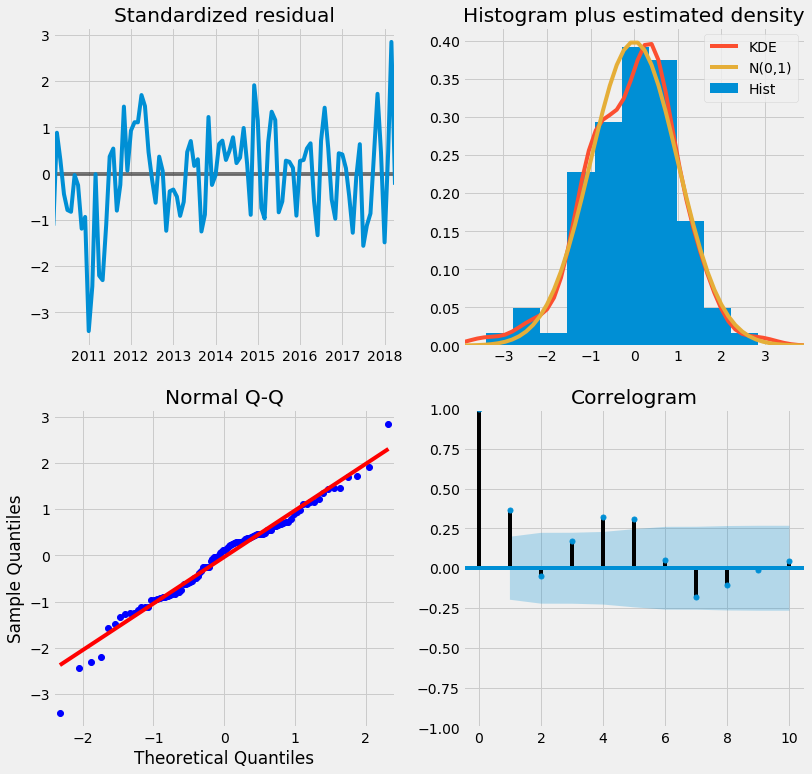

In [123]:
# fit model based on parameters above and display diagnostics
order = (2,0,1)
s_order = (1,0,1,12)
trend = 'n'

au_model = SARIMA_modeler(au_ts, order, s_order, trend)

model_details(au_model)

**Observations:** Normality assumptions look alright, would like to see a little more randomness in the standardized residual. AIC is about what we've been getting for other models. Most features are significant.  

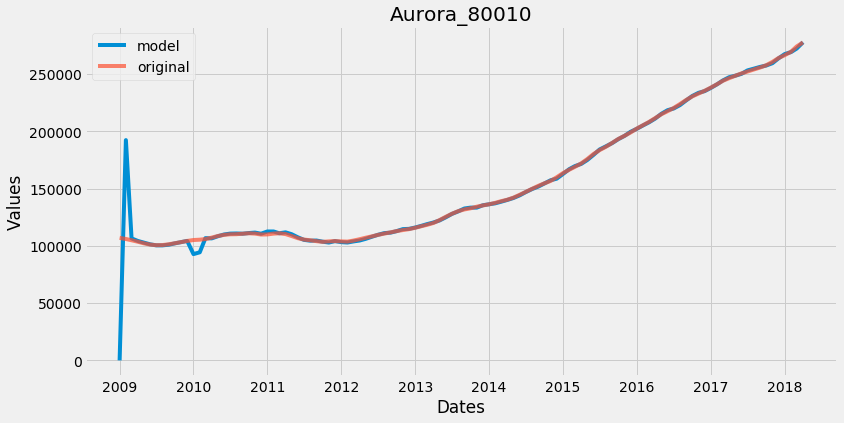

In [124]:
# plot original series and predicted values
plot_model(au_ts, au_model,title='Aurora_80010')

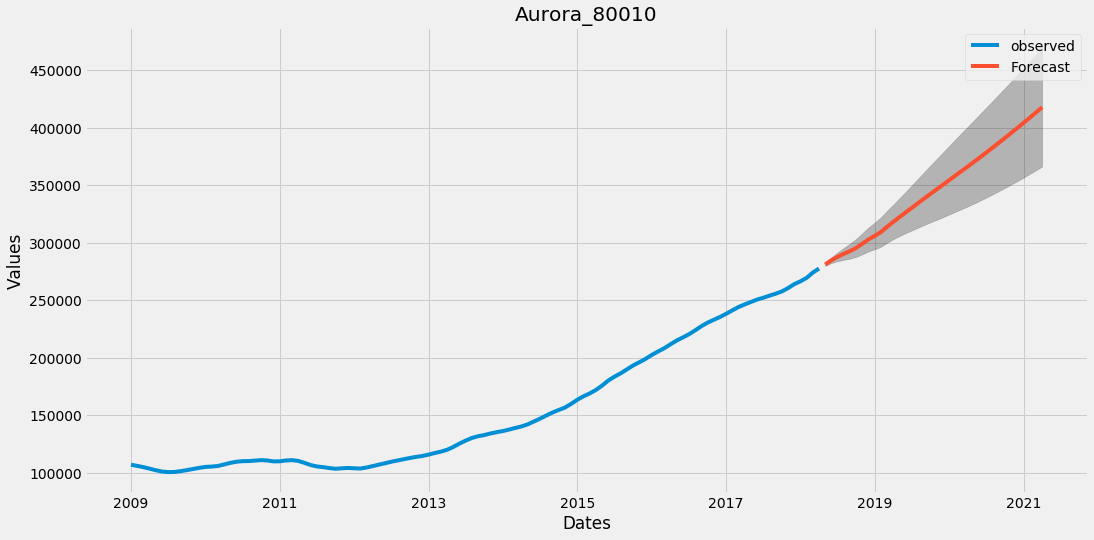

In [125]:
# plot forecast values 36 steps out with a 95% confidence interval
plot_forcast_model(au_ts, au_model, title= 'Aurora_80010', alpha=.05)

### Calculate ROI and expected growth - Aurora 

In [126]:
# calculate the expected growth interval for 36 periods forward with a 95% confidence interval
expected_growth(au_model, name='Aurora');

With a 95% confidence interval Aurora is forecasted to grow at the following rates after 36 months: 

	 Upper Rate: 66.3%
	 Mean Rate: 48.7%
	 Lower Rate: 30.9%

With a range of $103145.66 between the higest and lowest projected values.


In [127]:
ROI_calculator(model= au_model, ts= au_ts, name= 'Aurora')

An initial investment of $10000000.0 in Aurora would:

	 Allow us to buy approximately 36.0 properties.
	 With a mean projected growth of 48.7% over 36 months we would net a $4863379.11 return
	 or $135093.86416666667 per property.

	 With upper and lower growth rates at 66.3% and 30.9%,
	 we can project a total return between $3088264.59 and $6622694.72


### Aurora Conclusions

With a 35% confidence interval we're in a good range again, and similar mean expected growth at ~49% 

### Lake Worth Modeling

In [128]:
# Iterate through possible parameters with a 100-12 train-test split and select the lowest MSE
# SARIMA_MSE_Iterator(data=lw_ts, n_test=12, seasonal=[0,12])

Lake Worth

[(1, 0, 2), (2, 0, 0, 12), 'ct'] 490.61862163307904

[(0, 1, 1), (2, 0, 2, 12), 'ct'] 524.3138716754319

[(0, 1, 2), (0, 1, 0, 12), 't'] 545.9231119955433

Model coefficients:  intercept      -622.061448
drift            67.677602
ar.L1             0.977265
ma.L1             1.383312
ma.L2             0.630557
ar.S.L12          0.091790
ar.S.L24          0.005517
sigma2       597674.946547
dtype: float64

 Model p_values:  intercept    6.490543e-01
drift        3.742722e-01
ar.L1        3.649605e-92
ma.L1        7.290305e-05
ma.L2        4.672950e-02
ar.S.L12     8.149459e-01
ar.S.L24     7.773203e-01
sigma2       0.000000e+00
dtype: float64

 Model AIC:  1360.8059154388432


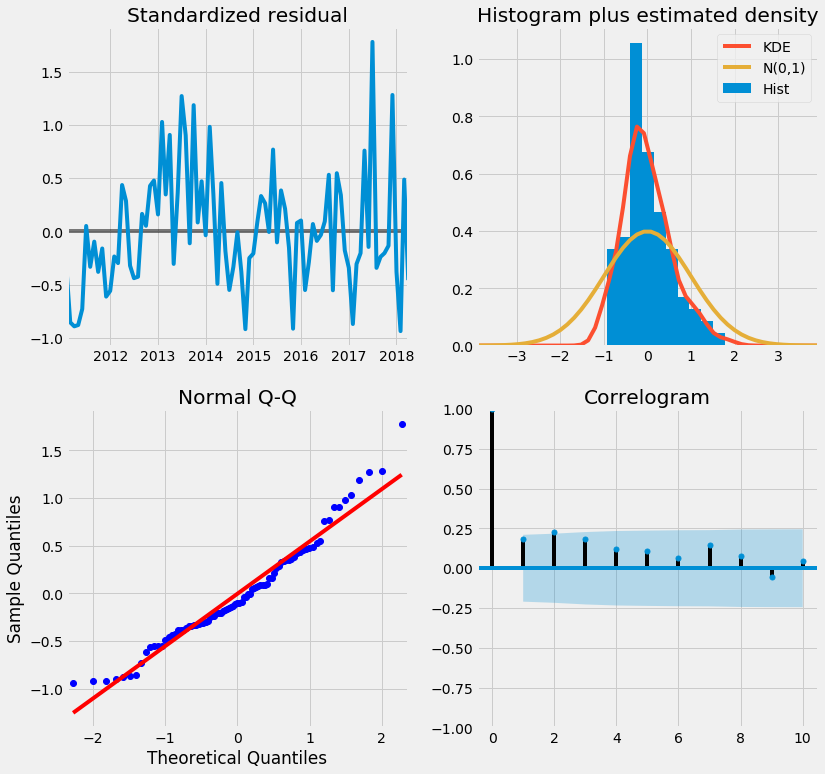

In [129]:
# fit model based on parameters above and display diagnostics
order = (1,0,2)
s_order = (2,0,0,12)
trend = 'ct'

lw_model = SARIMA_modeler(lw_ts, order, s_order, trend)

model_details(lw_model)

**Observations:** This model has the lowest AIC of the 3, but normality assumptions are not as easily met. Feature p-values are mostly not significant as well. 

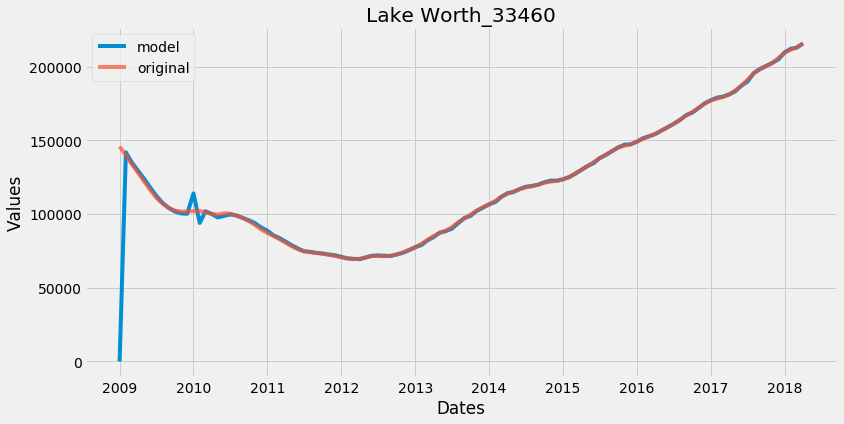

In [130]:
# plot original series and predicted values
plot_model(lw_ts, lw_model, title= 'Lake Worth_33460')

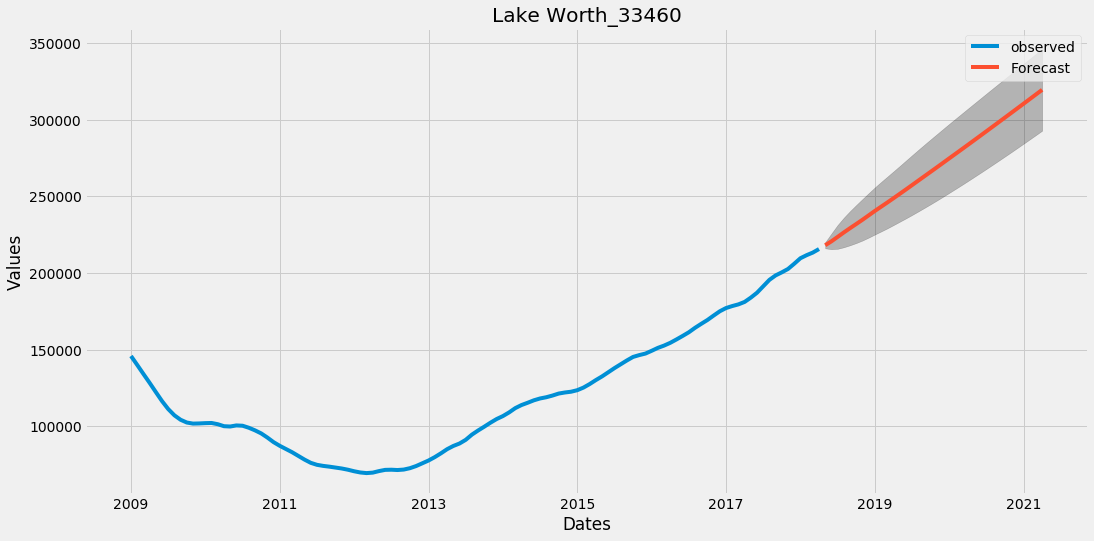

In [131]:
# plot forecast values 36 steps out with a 95% confidence interval
plot_forcast_model(lw_ts, lw_model, title= 'Lake Worth_33460')

### Calculate ROI and expected growth - Lake Worth

In [132]:
# calculate the expected growth interval for 36 periods forward with a 95% confidence interval
expected_growth(lw_model, name= 'Lake Worth');

With a 95% confidence interval Lake Worth is forecasted to grow at the following rates after 36 months: 

	 Upper Rate: 54.7%
	 Mean Rate: 46.5%
	 Lower Rate: 38.2%

With a range of $40582.35 between the higest and lowest projected values.


In [133]:
ROI_calculator(model=lw_model, ts=lw_ts, name= 'Lake Worth')

An initial investment of $10000000.0 in Lake Worth would:

	 Allow us to buy approximately 46.0 properties.
	 With a mean projected growth of 46.5% over 36 months we would net a $4613365.07 return
	 or $100290.54500000001 per property.

	 With upper and lower growth rates at 54.7% and 38.2%,
	 we can project a total return between $3785756.84 and $5429551.53


### Lake Worth Conclusions

With a 17% confidence interval this is the tightest model for the group, with slightly smaller expected men growth at ~46.5% 

## Lower Value Analysis Conclcusions

In this segment we are choosing between:

- A 4.9.6mm dollar, 50% return in **Vallejo**, with the opportunity to purchase 26 properties
    - a roughly 31% confidence interval, with upper and lower growth rates at 66.0% and 34.6%


- A 4.8mm dollar, 49% return in **Aurora**, with the opportunity to purchase 36 properties
    - a roughly 35% confidence interval, with upper and lower growth rates at 66.3% and 30.9%
    

- A 4.6mm dollar, 47% return in **Lake Worth**, with the opportunity to purchase 46 properties
    - a roughly 17% confidence interval, with upper and lower growth rates at 54.7% and 38.2%
  
Due the relatively similar returns we can look more to confidence interval to help make our choices. We will choose **Lake Worth 33460** and **Vallejo 94590**.

The lower end of the confidence interval for these areas also both exceed our benchmark 3 year growth rate of 20%. The opportunity to by 46 properties in Lake Worth may raise management challenges, but might also help spread risk

# Conclusions and Next Steps

We have now chosen five city_zipcodes as our investment targets they are: 
- High Value: San Jose 95116
- Medium Value: Union City 7087 and Jersey City 7306
- Lower Value:  Lake Worth 33460 and Vallejo 94590.

Let's do some quick calculations to see what the range of our total return will look like.


In [134]:
# disply the ROIs of our final choices again
ROI_calculator(model=sj_model3, ts=sj_ts, name='San Jose (Model 3)')
print('----' * 6)
ROI_calculator(model=uc_model_2, ts=uc_ts, name= 'Union City (Model 2)')
print('----' * 6)
ROI_calculator(model=jc_model, ts= jc_ts, name='Jersey City')
print('----' * 6)
ROI_calculator(model= va_model, ts= va_ts, name= 'Vallejo')
print('----' * 6)
ROI_calculator(model=lw_model, ts=lw_ts, name= 'Lake Worth')

An initial investment of $10000000.0 in San Jose (Model 3) would:

	 Allow us to buy approximately 13.0 properties.
	 With a mean projected growth of 55.7% over 36 months we would net a $5531594.02 return
	 or $425507.2323076923 per property.

	 With upper and lower growth rates at 58.8% and 52.5%,
	 we can project a total return between $5213892.19 and $5844074.46
------------------------
An initial investment of $10000000.0 in Union City (Model 2) would:

	 Allow us to buy approximately 22.0 properties.
	 With a mean projected growth of 67.0% over 36 months we would net a $6619359.12 return
	 or $300879.96 per property.

	 With upper and lower growth rates at 87.2% and 46.5%,
	 we can project a total return between $4591957.0 and $8608569.22
------------------------
An initial investment of $10000000.0 in Jersey City would:

	 Allow us to buy approximately 18.0 properties.
	 With a mean projected growth of 53.5% over 36 months we would net a $5254041.19 return
	 or $291891.1772222222

In [135]:
mean_returns = [5531594.02, 6619359.12, 5254041.19, 4924220.25, 4613365.07]
lower_returns = [5213892.19, 4591957.0, 4411976.04, 3379613.89, 3785756.84]
upper_returns = [5844074.46, 8608569.22, 6084205.2, 6454842.48, 5429551.53]

total_investment = 5e7

mean_predicted_growth = round(sum(mean_returns)/total_investment, 2) * 100
lower_predicted_growth = round(sum(lower_returns)/total_investment, 2) * 100
upper_predicted_growth = round(sum(upper_returns)/total_investment, 2) * 100

print(f'''The combination of our 5 investments is projected to grow:
        {mean_predicted_growth}%, for a return of ${round(sum(mean_returns), 2)}\n''')

print(F'''At the upper and lower end of our projections we may see:
          Upper: {upper_predicted_growth}%, for a return of ${round(sum(upper_returns), 2)}
          Lower: {lower_predicted_growth}%, for a return of ${round(sum(lower_returns), 2)}''')

The combination of our 5 investments is projected to grow:
        54.0%, for a return of $26942579.65

At the upper and lower end of our projections we may see:
          Upper: 65.0%, for a return of $32421242.89
          Lower: 43.0%, for a return of $21383195.96


#### Next steps:

As our modeling method is univariate, meaning that it only takes historical value data into account to form it's predictions, it is heavily dependent on past performance and does not factor in other exogenous variables. To account for this we recommend the following two steps:
1. Conduct thorough qualitative market analysis to include local political, tax, and business development trends to insure there are not unknown market moving events expected within the near future
2. Reproduce this analysis on a quarterly or monthly basis to monitor how current prices are effecting future predictions and to check for model performance